## Steps
1. Camera Calibration
2. Distortion Correction
3. Color and Gradient Threshold
4. Perspective Transform
5. Detect Lane Lines
6. Determine Lane Curvature
7. Impose Lane Boundaries on Original Image
8. Pipeline

In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob2
from moviepy.editor import VideoFileClip
import math
from collections import deque
#%matplotlib qt  
%matplotlib inline



### 1. Camera Calibration

In [2]:

def calibrate_camera(images, nx, ny, display=True):
    objpoints = []
    imgpoints = []
    
    ## object points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    img_size = None
    # Make a list of calibration images
    plt.figure(figsize = (15,10))
   
    for i, im in enumerate(images ):
        img = cv2.imread(im)
        #print('Finding chessboard corners on {}'.format(im))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        if ( display ):
            plt.subplot(4,5,i+1)
            plt.axis('off')
            plt.imshow(img)
        
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        print( "Calibration Failed" )
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    return mtx, dist



In [3]:
def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

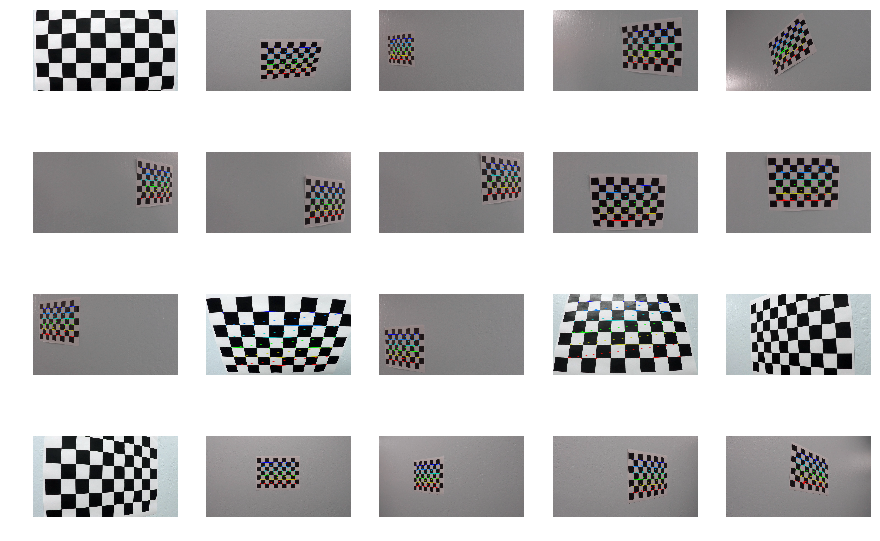

In [4]:
cal_dir = './camera_cal/'
cal_file = cal_dir+'calibration'
calibration_images = glob2.glob(cal_file+'*'+'.jpg')
mtx, dist = calibrate_camera(calibration_images, 9, 6)



### 2. Distortion Correction

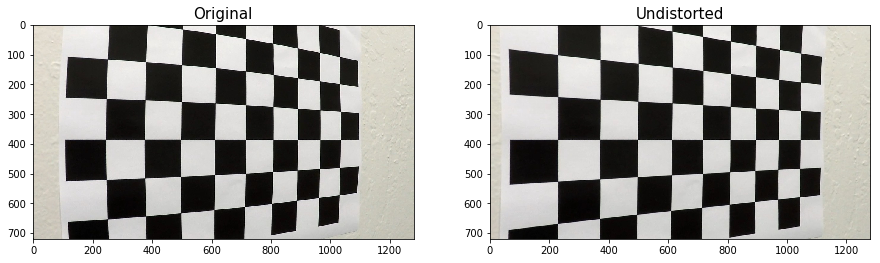

In [5]:
test_img = mpimg.imread("./camera_cal/calibration5.jpg")
undist_img = undistort(test_img, mtx, dist)
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('Original', fontsize=15)
plt.subplot(1,2,2)
plt.imshow(undist_img)
plt.title('Undistorted', fontsize=15)

### 3. Color and Gradient Threshold

In [29]:
def convert_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls

def convert_luv(img):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    return luv

def convert_hsv(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return hsv

def convert_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

def apply_gaussian_blur(img, kernel=5):
    # Function to smooth image
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def get_mask( t_img, thresh):
    mask = np.zeros_like(t_img)
    mask[(t_img >= thresh[0]) & (t_img <= thresh[1]) ] = 1
    return mask
    
# Calculate directional gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    ## img to gray
    gray = convert_gray(img)
    # Apply threshold
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255*sobel_abs/np.max(sobel_abs))

    return get_mask(sobel_scaled, thresh)

# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, thresh=(50, 255)):
    ## img to gray
    
    gray = convert_gray(img)
    #print(gray.shape)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobelxy = np.sqrt((np.power(sobelx,2)+np.power(sobely,2)) )
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    return get_mask(scaled_sobel, thresh)


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = convert_gray(img)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    return get_mask(absgraddir, thresh)


def dir_threshold2(img, sobel_kernel=3, thresh=(0, np.pi/2)):
	# Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_combined(image):
    # Combine sobel masks.
    img_g_mag = mag_thresh(image,3,(50,255))
    img_d_mag = dir_threshold2(image,15,(.7,1.2))
    img_abs_x = abs_sobel_thresh(image,'x',15,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',15,(50,200))
        
    sobel_combined = np.zeros_like(img_d_mag)
    
    sobel_combined[ ( ((img_abs_x == 1)  | (img_g_mag == 1)  & (img_d_mag == 1)) )] = 1
    return sobel_combined


def color_threshold(img):
    hsv = convert_hsv(img)
    
    ## Yellow lane
    yellow_min = np.array([15, 100, 100], np.uint8)
    yellow_max = np.array([100, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(hsv, yellow_min, yellow_max)
    ## white lane
    sensitivity = 15
    white_min = np.array([0, 0,200 ], np.uint8)
    white_max = np.array([255, 80, 255], np.uint8)
    white_mask = cv2.inRange(hsv, white_min, white_max)
    
    
    
    ## HLS channels
    hls = convert_hls(img)
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    s_thresh = (100, 255)
    h_thresh = (15, 100)
    
    s_mask = get_mask(s_channel, s_thresh)
    h_mask = get_mask(h_channel, h_thresh)

    ## RGB channels
    r_channel = img[:,:,2]
    r_thesh = (200, 255)
    r_mask = get_mask(r_channel, r_thesh)
    
    color_mask =    (s_mask | r_mask  ) & h_mask  #s_mask | h_mask & r_mask
    combined_mask = np.zeros_like(color_mask)
    combined_mask[(( (yellow_mask != 0 ) | (white_mask != 0) ) & ( color_mask==1) ) ] = 1
        
    return combined_mask


### 4.Prespective Transform

In [7]:
def apply_perspective_transform(image):
    img_size = (image.shape[1], image.shape[0] )
    
    src = np.float32([
            [580, 460],
            [700, 460],
            [1040, 680],
            [260, 680],])

    dst = np.float32([
            [260, 0],
            [1040, 0],
            [1040, 720],
            [260, 720],])
    #src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
    # = np.float32([[250,700],[1200,700],[300,50],[1000,50]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size)
    return warped


def apply_reverse_prespective_transform(image):
    img_size = (image.shape[1], image.shape[0] )
    
    src = np.float32([
            [580, 460],
            [700, 460],
            [1040, 680],
            [260, 680],])

    dst = np.float32([
            [260, 0],
            [1040, 0],
            [1040, 720],
            [260, 720],])
    #src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
    #dst = np.float32([[250,700],[1200,700],[300,50],[1000,50]])

    M_inverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M_inverse, img_size)
    return warped


### 5.Detect Lane Lines

In [65]:

def fit_line( x, y, degree=2 ):
    fit = None
    if( len(x) >0 and len(y) >0 ) :
        fit = np.polyfit(y, x, 2)
    
    return fit

def detect_lines_sliding_window(img, previous_lines, prev_count):

    if ( previous_lines and prev_count < 5 ):
        ## use previous frames for finding lines
        return detect_lines_regress(img, previous_lines,prev_count)
    
    histogram = np.sum(img[int(img.shape[0] / 2):, :], axis=0)
    out_img = np.dstack((img, img, img)) * 255
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(img.shape[0] / nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 140
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    leftx, lefty = reject_outliers( leftx, lefty )
    rightx, righty = reject_outliers( rightx, righty )
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ## set previous rejected frame count to zero
    prev_count = 0
    return  (leftx, lefty), (rightx, righty)


def reject_outliers(x_list, y_list):
    if len(x_list) <= 1 or len( y_list ) <= 1:
        return x_list, y_list
    mu_x, mu_y = np.mean(x_list), np.mean(y_list)
    sig_x, sig_y = np.std(x_list), np.std(y_list)
   
    new_x, new_y = [],[]
    for (x,y) in zip(x_list, y_list ):
        if ( abs(x - mu_x ) < 2*sig_x and abs(y - mu_y) < 2*sig_y ):
            new_x.append(x)
            new_y.append(y)
    
    return new_x, new_y

def detect_lines_regress( image,previous_lines, prev_count ):
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 140
    
    left_fit = previous_lines[-1][2]
    right_fit = previous_lines[-1][3]
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #leftx, lefty = reject_outliers( leftx, lefty )
    #rightx, righty = reject_outliers( rightx, righty )
    
    ## need atleast 10 points 
    #min_inds = 10
    #if len(lefty) < min_inds or len(righty) < min_inds:
    #    print ("Warning:Not enough points")
    #   return ( None,None )
    
    return  (leftx, lefty), (rightx, righty) 

            

def get_average_coefficients( l_fit, r_fit, previous_lines, prev_count ):
    prev_l_fit = previous_lines[-1][2]
    prev_r_fit = previous_lines[-1][3]
    err_R = 1.
    err_L = 1.
     ## Check error between current coefficient and on from previous frame
    if l_fit is not None and r_fit is not None: 
        err_R = np.sqrt( np.sum((r_fit[0]-prev_r_fit[0])**2) ) 
        err_L = np.sqrt( np.sum((l_fit[0]-prev_l_fit[0])**2) )
        
    ## last 16 frames had error    
    if ( prev_count >= 5 ):
        return (l_fit, r_fit)
    
    if  err_R >.0005 :
        print('Warning: Right Coefficient Error - {}'.format(err_R))
        r_fit = prev_r_fit
        prev_count +=1
    else:
        r_fit = .25*r_fit+.75*prev_r_fit
    
    if err_L>.0005:
        print('Warning: Left Coefficient Error - {}'.format(err_L))
        l_fit = prev_l_fit
        prev_count +=1
    else:
        l_fit = .25*l_fit+.75*prev_l_fit
    return (l_fit, r_fit)

### 6. Determine Lane Curvature

In [66]:
def measure_curvature(img,  left_fit, right_fit):

    ## change to real world vals
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = 719 # 720p video/image, so last (lowest on screen) y index is 719
    

    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    ratio = left_curverad / right_curverad
    if ratio < 0.66 or ratio > 1.5:
        print('Warning: shitty ratio {}'.format(ratio))
    
    lane_leftx = left_fit[0] * (img.shape[0] - 1) ** 2 + left_fit[1] * (img.shape[0] - 1) + left_fit[2]
    lane_rightx = right_fit[0] * (img.shape[0] - 1) ** 2 + right_fit[1] * (img.shape[0] - 1) + right_fit[2]

    car_pos = ((img.shape[1] / 2) - ((lane_leftx + lane_rightx) / 2)) * xm_per_pix 

    return (left_curverad + right_curverad) / 2, car_pos.round(2)
    
    

### 7.Impose Lane Boundaries on Original Image

In [67]:
def draw_poly( img, left_fit, right_fit):
    color_warp = np.zeros_like(img).astype(np.uint8)
    fity = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
    right_fitx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
    pts = np.hstack((pts_left, pts_right))
    pts = np.array(pts, dtype=np.int32)

    cv2.fillPoly(color_warp, pts, (0, 255, 0))
    
     # Draw lane markers
    cv2.drawContours(color_warp, pts_right.reshape((-1,1,2)).astype(np.int32), -1, (0,0,255), thickness=30)
    cv2.drawContours(color_warp, pts_left.reshape((-1,1,2)).astype(np.int32), -1, (255,0,0), thickness=30)
   
    newwarp = apply_reverse_prespective_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result


### 8.Pipeline

In [68]:
def pipeline(image, mtx, dist, previous_lines, prev_count):
    ## global variables
    img_size = (image.shape[1], image.shape[0])
    
    ## undistort image
    image_undis =  undistort(image, mtx, dist)
    
    ## apply gaussian blur
    image_g = apply_gaussian_blur(image_undis)
    ## prespective transform 
    image_trans = apply_perspective_transform(image_g)
    
    ##apply sobel 
    sobel_mask = sobel_combined(image_trans)
    ## color threshold
    color_mask = color_threshold(image_trans)
    
    
    ## combined 
    mask = np.zeros_like(sobel_mask).astype(np.uint8)
    mask[((sobel_mask== 1) | ( color_mask==1) )] = 1

    #print("Mask ready ..")
    ##lanes
    left_points, right_points = None,None
    l_fit, r_fit = None,None
    temp_p_count = prev_count
    left_points, right_points = detect_lines_sliding_window(mask, previous_lines, prev_count)
    
    '''if ( previous_lines and prev_count < 16 ):
        ## use previous frames for finding lines
        #print("Get lane points regress..")
        left_points, right_points = detect_lines_regress(img, previous_lines, prev_count)
    else: 
        #print("Get lane points window..")
        left_points, right_points = detect_lines_sliding_window(mask, previous_lines, prev_count)
    
    if ( left_points is None or right_points is None ):
        #left_points, right_points = detect_lines_sliding_window(mask, previous_lines, prev_count)
        ## use previous frame
        left_points = previous_lines[-1][0]
        right_points = previous_lines[-1][1]
        prev_count +=1'''
    
        
    l_fit = fit_line(left_points[0], left_points[1])
    r_fit = fit_line(right_points[0], right_points[1])
     
    ### Visualization code
    '''ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0] )
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    out_img = np.dstack((mask, mask, mask))*255
    window_img = np.zeros_like(out_img)
    nonzero = mask.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Color in left and right line pixels
    out_img[left_points[1], left_points[0]] = [255, 0, 0]
    out_img[right_points[1], right_points[0]] = [0, 0, 255]
  
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return'''
    #-------------------------
    ## if first frame -- add that as the previous frame
    if not previous_lines : 
        previous_lines.append((left_points, right_points, l_fit, r_fit))
    
    #print("Get average coefficients..")
    ## do sanity check & get coordinates averaged
    l_fit, r_fit = get_average_coefficients( l_fit, r_fit, previous_lines, prev_count )
    
    ## add this to history
    ## only add to history if new lines detected
    if ( temp_p_count == prev_count ):
        previous_lines.append((left_points, right_points, l_fit, r_fit))
    
    #print("Draw poly..")
    #print( l_fit, r_fit)
    res = draw_poly(image_undis, l_fit, r_fit)    
    
    lane_curve, car_pos = measure_curvature(image_undis, l_fit, r_fit)

    ## get curves
    if car_pos > 0:
        car_pos_text = '{0:.2f}m right of center'.format(car_pos)
    else:
        car_pos_text = '{0:.2f}m left of center'.format(abs(car_pos))

    cv2.putText(res, "Lane curve: {}m".format(lane_curve.round()), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1,
                color=(255, 255, 255), thickness=2)
    cv2.putText(res, "Car is {}".format(car_pos_text), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                color=(255, 255, 255),thickness=2)
    
    
  
    return res

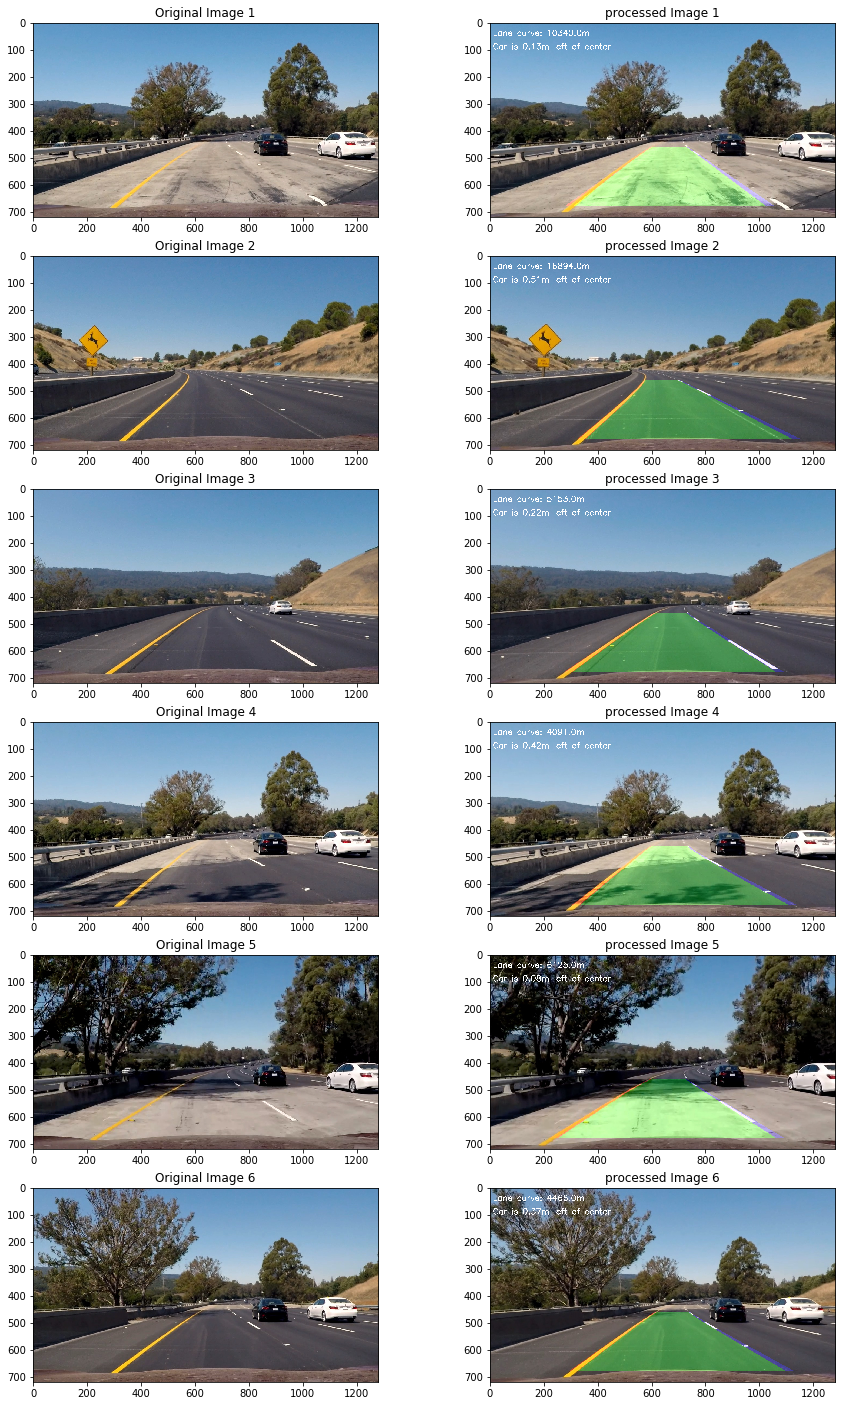

In [69]:
## test code 

plt.figure(figsize=(15, 25))
c = 1
previous_lines = deque(maxlen=3)
for i in range(6):
    num = i+1
    img = mpimg.imread("./test_images/test"+str(num)+".jpg")
    plt.subplot(6, 2,c)
    plt.imshow(img)
    plt.title("Original Image "+str(num))
    c += 1
    plt.subplot(6, 2,c)
    c += 1
    processed = pipeline(img, mtx, dist, previous_lines, 16)
    plt.imshow(processed)
    plt.title("processed Image "+str(num))
    


In [70]:

# Video writer
input_file = "./project_video.mp4"
output_file = './project_video_out2.mp4'
clip1 = VideoFileClip(input_file)
previous_lines = deque(maxlen=3)
prev_count = 0
clip = clip1.fl_image(lambda img : pipeline( img, mtx, dist, previous_lines, prev_count) ) 
%time clip.write_videofile(output_file, audio=False)



[MoviePy] >>>> Building video ./project_video_out2.mp4
[MoviePy] Writing video ./project_video_out2.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<07:03,  2.98it/s]


  0%|          | 2/1261 [00:00<07:04,  2.97it/s]


  0%|          | 3/1261 [00:01<07:02,  2.98it/s]


  0%|          | 4/1261 [00:01<08:03,  2.60it/s]


  0%|          | 5/1261 [00:01<07:51,  2.66it/s]


  0%|          | 6/1261 [00:02<07:31,  2.78it/s]


  1%|          | 7/1261 [00:02<07:22,  2.84it/s]


  1%|          | 8/1261 [00:02<07:32,  2.77it/s]


  1%|          | 9/1261 [00:03<07:19,  2.85it/s]


  1%|          | 10/1261 [00:03<07:15,  2.87it/s]


  1%|          | 11/1261 [00:03<07:08,  2.92it/s]


  1%|          | 12/1261 [00:04<07:13,  2.88it/s]


  1%|          | 13/1261 [00:04<07:17,  2.85it/s]


  1%|          | 14/1261 [00:04<07:10,  2.89it/s]


  1%|          | 15/1261 [00:05<07:02,  2.95it/s]


  1%|▏         | 16/1261 [00:05<06:56,  2.99it/s]


  1%|▏         | 17/1261 [00:06<07:35,  2.73it/s]


  1%|▏         | 18/1261 [00:06<08:34,  2.42it/s]


  2%|▏         | 19/1261 [0




  2%|▏         | 21/1261 [00:07<07:42,  2.68it/s]


  2%|▏         | 22/1261 [00:07<07:26,  2.77it/s]


  2%|▏         | 23/1261 [00:08<07:13,  2.86it/s]


  2%|▏         | 24/1261 [00:08<07:04,  2.91it/s]


  2%|▏         | 25/1261 [00:08<07:00,  2.94it/s]


  2%|▏         | 26/1261 [00:09<06:53,  2.99it/s]




  2%|▏         | 27/1261 [00:09<06:53,  2.99it/s]




  2%|▏         | 28/1261 [00:09<06:54,  2.97it/s]


  2%|▏         | 29/1261 [00:10<06:48,  3.01it/s]


  2%|▏         | 30/1261 [00:10<06:45,  3.03it/s]


  2%|▏         | 31/1261 [00:10<06:45,  3.03it/s]


  3%|▎         | 32/1261 [00:11<06:41,  3.06it/s]


  3%|▎         | 33/1261 [00:11<06:41,  3.06it/s]


  3%|▎         | 34/1261 [00:11<06:39,  3.07it/s]


  3%|▎         | 35/1261 [00:12<06:38,  3.08it/s]


  3%|▎         | 36/1261 [00:12<07:24,  2.75it/s]


  3%|▎         | 37/1261 [00:13<07:41,  2.65it/s]


  3%|▎         | 38/1261 [00:13<07:49,  2.61it/s]


  3%|▎         | 39/1261 [00:13<07:56,  2.57it/s]


  3%|▎         | 40/1261 [00:14<07:26,  2.74it/s]


  3%|▎         | 41/1261 [00:14<07:07,  2.86it/s]


  3%|▎         | 42/1261 [00:14<07:27,  2.72it/s]


  3%|▎         | 43/1261 [00:15<07:40,  2.65it/s]


  3%|▎         | 44/1261 [00:15<07:17,  2.78it/s]


  4%|▎         | 45/1261 [00:15<07:00,  2.89it/s]


  4%|▎         | 46/1261 [00:16<06:46,  2.99it/s]


  4%|▎   




  6%|▌         | 70/1261 [00:24<06:40,  2.97it/s]




  6%|▌         | 71/1261 [00:24<07:30,  2.64it/s]




  6%|▌         | 72/1261 [00:24<07:21,  2.69it/s]


  6%|▌         | 73/1261 [00:25<07:05,  2.79it/s]


  6%|▌         | 74/1261 [00:25<06:53,  2.87it/s]


  6%|▌         | 75/1261 [00:25<06:44,  2.93it/s]


  6%|▌         | 76/1261 [00:26<06:39,  2.97it/s]


  6%|▌         | 77/1261 [00:26<06:39,  2.96it/s]


  6%|▌         | 78/1261 [00:26<06:37,  2.97it/s]


  6%|▋         | 79/1261 [00:27<06:38,  2.97it/s]


  6%|▋         | 80/1261 [00:27<06:33,  3.00it/s]




  6%|▋         | 81/1261 [00:27<06:30,  3.02it/s]




  7%|▋         | 82/1261 [00:28<06:34,  2.99it/s]




  7%|▋         | 83/1261 [00:28<06:31,  3.01it/s]




  7%|▋         | 84/1261 [00:28<06:26,  3.04it/s]




  7%|▋         | 85/1261 [00:29<06:24,  3.06it/s]




  7%|▋         | 86/1261 [00:29<06:22,  3.07it/s]




  7%|▋         | 87/1261 [00:29<06:22,  3.07it/s]




  7%|▋         | 88/1261 [00:30<06:22,  3.06it/s]




  7%|▋         | 89/1261 [00:30<06:18,  3.10it/s]


  7%|▋         | 90/1261 [00:30<06:21,  3.07it/s]


  7%|▋         | 91/1261 [00:31<06:31,  2.99it/s]


  7%|▋         | 92/1261 [00:31<06:29,  3.00it/s]


  7%|▋         | 93/1261 [00:31<06:26,  3.02it/s]


  7%|▋         | 94/1261 [00:32<06:23,  3.04it/s]


  8%|▊         | 95/1261 [00:32<06:21,  3.06it/s]


  8%|▊         | 96/1261 [00:32<06:22,  3.05it/s]


  8%|▊         | 97/1261 [00:33<06:48,  2.85it/s]


  8%|▊         | 98/1261 [00:33<07:07,  2.72it/s]


  8%|▊         | 99/1261 [00:33<06:58,  2.78it/s]


  8%|▊         | 100/1261 [00:34<06:46,  2.86it/s]


  8%|▊         | 101/1261 [00:34<06:36,  2.92it/s]


  8%|▊         | 102/1261 [00:34<06:30,  2.97it/s]


  8%|▊         | 103/1261 [00:35<06:23,  3.02it/s]


  8%|▊         | 104/1261 [00:35<06:26,  2.99it/s]


  8%|▊         | 105/1261 [00:35<06:29,  2.97it/s]


  8%|▊         | 106/1261 [00:36<06:28,  2.97it/s]


  8%|▊         | 107/1261 [00:36<06:26,  2.99it/s]


 




 13%|█▎        | 169/1261 [00:57<05:59,  3.04it/s]




 13%|█▎        | 170/1261 [00:58<05:56,  3.06it/s]




 14%|█▎        | 171/1261 [00:58<05:59,  3.03it/s]


 14%|█▎        | 172/1261 [00:58<05:57,  3.05it/s]


 14%|█▎        | 173/1261 [00:59<05:58,  3.03it/s]


 14%|█▍        | 174/1261 [00:59<05:56,  3.05it/s]


 14%|█▍        | 175/1261 [00:59<05:55,  3.06it/s]


 14%|█▍        | 176/1261 [01:00<05:54,  3.06it/s]


 14%|█▍        | 177/1261 [01:00<05:59,  3.02it/s]




 14%|█▍        | 178/1261 [01:00<06:08,  2.94it/s]




 14%|█▍        | 179/1261 [01:01<06:19,  2.85it/s]




 14%|█▍        | 180/1261 [01:01<06:32,  2.75it/s]




 14%|█▍        | 181/1261 [01:01<06:57,  2.59it/s]




 14%|█▍        | 182/1261 [01:02<07:04,  2.54it/s]


 15%|█▍        | 183/1261 [01:02<07:12,  2.49it/s]


 15%|█▍        | 184/1261 [01:03<07:29,  2.40it/s]


 15%|█▍        | 185/1261 [01:03<07:58,  2.25it/s]


 15%|█▍        | 186/1261 [01:04<08:07,  2.20it/s]


 15%|█▍        | 187/1261 [01:04<08:31,  2.10it/s]


 15%|█▍        | 188/1261 [01:05<07:54,  2.26it/s]


 15%|█▍        | 189/1261 [01:05<07:25,  2.41it/s]


 15%|█▌        | 190/1261 [01:05<07:07,  2.51it/s]


 15%|█▌        | 191/1261 [01:06<06:54,  2.58it/s]


 15%|█▌        | 192/1261 [01:06<06:39,  2.68it/s]


 15%|█▌        | 193/1261 [01:06<06:29,  2.74it/s]


 15%|█▌        | 194/1261 [01:07<06:24,  2.77it/s]


 15%|█▌        | 195/1261 [01:07<06:16,  2.83it/s]


 16%|█▌        | 196/1261 [01:07<06:10,  2.87it/s]


 16%|█▌        | 197/1261 [01:08<06:06,  2.90it/s]


 16%|█▌        | 198/1261 [01:08<05:59,  2.95it/s]


 16%|█▌        | 199/1261 [01:08<05:56,  2.98it/s]


 16%|█▌        | 200/1261 [01:09<06:06,  2.




 24%|██▎       | 298/1261 [01:42<05:15,  3.05it/s]




 24%|██▎       | 299/1261 [01:43<05:26,  2.95it/s]


 24%|██▍       | 300/1261 [01:43<05:22,  2.98it/s]


 24%|██▍       | 301/1261 [01:44<05:19,  3.00it/s]


 24%|██▍       | 302/1261 [01:44<05:19,  3.00it/s]


 24%|██▍       | 303/1261 [01:44<05:29,  2.90it/s]


 24%|██▍       | 304/1261 [01:45<05:34,  2.86it/s]




 24%|██▍       | 305/1261 [01:45<05:33,  2.87it/s]




 24%|██▍       | 306/1261 [01:45<05:29,  2.90it/s]




 24%|██▍       | 307/1261 [01:46<05:22,  2.95it/s]




 24%|██▍       | 308/1261 [01:46<05:16,  3.01it/s]




 25%|██▍       | 309/1261 [01:46<05:12,  3.04it/s]




 25%|██▍       | 310/1261 [01:47<05:07,  3.09it/s]


 25%|██▍       | 311/1261 [01:47<05:06,  3.10it/s]


 25%|██▍       | 312/1261 [01:47<05:04,  3.11it/s]




 25%|██▍       | 313/1261 [01:47<05:00,  3.16it/s]




 25%|██▍       | 314/1261 [01:48<04:56,  3.19it/s]




 25%|██▍       | 315/1261 [01:48<04:53,  3.22it/s]




 25%|██▌       | 316/1261 [01:48<04:52,  3.23it/s]




 25%|██▌       | 317/1261 [01:49<04:54,  3.20it/s]




 25%|██▌       | 318/1261 [01:49<04:54,  3.21it/s]




 25%|██▌       | 319/1261 [01:49<04:50,  3.25it/s]


 25%|██▌       | 320/1261 [01:50<04:53,  3.21it/s]


 25%|██▌       | 321/1261 [01:50<04:53,  3.20it/s]


 26%|██▌       | 322/1261 [01:50<04:51,  3.22it/s]




 26%|██▌       | 323/1261 [01:51<04:48,  3.25it/s]




 26%|██▌       | 324/1261 [01:51<04:46,  3.27it/s]




 26%|██▌       | 325/1261 [01:51<04:47,  3.26it/s]




 26%|██▌       | 326/1261 [01:51<04:46,  3.27it/s]




 26%|██▌       | 327/1261 [01:52<04:46,  3.26it/s]




 26%|██▌       | 328/1261 [01:52<04:44,  3.28it/s]




 26%|██▌       | 329/1261 [01:52<04:45,  3.27it/s]




 26%|██▌       | 330/1261 [01:53<04:49,  3.21it/s]




 26%|██▌       | 331/1261 [01:53<04:50,  3.20it/s]




 26%|██▋       | 332/1261 [01:53<04:54,  3.16it/s]




 26%|██▋       | 333/1261 [01:54<05:08,  3.01it/s]




 26%|██▋       | 334/1261 [01:54<05:26,  2.84it/s]




 27%|██▋       | 335/1261 [01:55<05:49,  2.65it/s]




 27%|██▋       | 336/1261 [01:55<05:50,  2.64it/s]




 27%|██▋       | 337/1261 [01:55<05:33,  2.77it/s]




 27%|██▋       | 338/1261 [01:56<05:20,  2.88it/s]




 27%|██▋       | 339/1261 [01:56<05:13,  2.94it/s]




 27%|██▋       | 340/1261 [01:56<05:06,  3.01it/s]




 27%|██▋       | 341/1261 [01:57<05:00,  3.06it/s]




 27%|██▋       | 342/1261 [01:57<04:54,  3.12it/s]




 27%|██▋       | 343/1261 [01:57<04:52,  3.14it/s]




 27%|██▋       | 344/1261 [01:57<04:52,  3.14it/s]




 27%|██▋       | 345/1261 [01:58<04:47,  3.18it/s]




 27%|██▋       | 346/1261 [01:58<04:47,  3.18it/s]




 28%|██▊       | 347/1261 [01:58<04:46,  3.19it/s]




 28%|██▊       | 348/1261 [01:59<04:47,  3.17it/s]




 28%|██▊       | 349/1261 [01:59<04:47,  3.17it/s]




 28%|██▊       | 350/1261 [01:59<04:44,  3.21it/s]


 28%|██▊       | 351/1261 [02:00<04:42,  3.22it/s]


 28%|██▊       | 352/1261 [02:00<04:42,  3.22it/s]




 28%|██▊       | 353/1261 [02:00<04:40,  3.24it/s]




 28%|██▊       | 354/1261 [02:01<04:41,  3.22it/s]


 28%|██▊       | 355/1261 [02:01<04:41,  3.22it/s]




 28%|██▊       | 356/1261 [02:01<04:41,  3.21it/s]




 28%|██▊       | 357/1261 [02:02<04:40,  3.22it/s]




 28%|██▊       | 358/1261 [02:02<04:40,  3.22it/s]




 28%|██▊       | 359/1261 [02:02<04:40,  3.22it/s]




 29%|██▊       | 360/1261 [02:02<04:40,  3.21it/s]




 29%|██▊       | 361/1261 [02:03<04:42,  3.19it/s]




 29%|██▊       | 362/1261 [02:03<04:43,  3.17it/s]




 29%|██▉       | 363/1261 [02:03<04:45,  3.14it/s]




 29%|██▉       | 364/1261 [02:04<04:47,  3.12it/s]


 29%|██▉       | 365/1261 [02:04<04:46,  3.12it/s]




 29%|██▉       | 366/1261 [02:04<04:46,  3.13it/s]




 29%|██▉       | 367/1261 [02:05<04:44,  3.14it/s]


 29%|██▉       | 368/1261 [02:05<04:42,  3.16it/s]


 29%|██▉       | 369/1261 [02:05<04:39,  3.19it/s]




 29%|██▉       | 370/1261 [02:06<04:38,  3.20it/s]




 29%|██▉       | 371/1261 [02:06<04:37,  3.21it/s]




 30%|██▉       | 372/1261 [02:06<04:36,  3.22it/s]




 30%|██▉       | 373/1261 [02:07<04:35,  3.23it/s]




 30%|██▉       | 374/1261 [02:07<04:34,  3.23it/s]




 30%|██▉       | 375/1261 [02:07<04:34,  3.22it/s]




 30%|██▉       | 376/1261 [02:07<04:36,  3.20it/s]




 30%|██▉       | 377/1261 [02:08<04:34,  3.22it/s]




 30%|██▉       | 378/1261 [02:08<04:35,  3.20it/s]




 30%|███       | 379/1261 [02:08<04:34,  3.21it/s]




 30%|███       | 380/1261 [02:09<04:35,  3.20it/s]




 30%|███       | 381/1261 [02:09<04:33,  3.22it/s]




 30%|███       | 382/1261 [02:09<04:31,  3.24it/s]




 30%|███       | 383/1261 [02:10<04:30,  3.24it/s]


 30%|███       | 384/1261 [02:10<04:30,  3.24it/s]


 31%|███       | 385/1261 [02:10<04:30,  3.24it/s]


 31%|███       | 386/1261 [02:11<04:29,  3.25it/s]


 31%|███       | 387/1261 [02:11<04:28,  3.25it/s]


 31%|███       | 388/1261 [02:11<04:29,  3.24it/s]


 31%|███       | 389/1261 [02:12<04:28,  3.25it/s]




 31%|███       | 390/1261 [02:12<04:27,  3.25it/s]




 31%|███       | 391/1261 [02:12<04:29,  3.23it/s]




 31%|███       | 392/1261 [02:12<04:28,  3.24it/s]




 31%|███       | 393/1261 [02:13<04:28,  3.23it/s]




 31%|███       | 394/1261 [02:13<04:31,  3.20it/s]




 31%|███▏      | 395/1261 [02:13<04:30,  3.20it/s]




 31%|███▏      | 396/1261 [02:14<04:33,  3.17it/s]




 31%|███▏      | 397/1261 [02:14<04:30,  3.19it/s]




 32%|███▏      | 398/1261 [02:14<04:28,  3.22it/s]




 32%|███▏      | 399/1261 [02:15<04:27,  3.22it/s]


 32%|███▏      | 400/1261 [02:15<04:26,  3.24it/s]


 32%|███▏      | 401/1261 [02:15<04:26,  3.23it/s]


 32%|███▏      | 402/1261 [02:16<04:25,  3.23it/s]


 32%|███▏      | 403/1261 [02:16<04:25,  3.23it/s]


 32%|███▏      | 404/1261 [02:16<04:25,  3.23it/s]


 32%|███▏      | 405/1261 [02:16<04:26,  3.21it/s]


 32%|███▏      | 406/1261 [02:17<04:25,  3.22it/s]


 32%|███▏      | 407/1261 [02:17<04:24,  3.23it/s]


 32%|███▏      | 408/1261 [02:17<04:22,  3.25it/s]




 32%|███▏      | 409/1261 [02:18<04:24,  3.23it/s]




 33%|███▎      | 410/1261 [02:18<04:23,  3.23it/s]




 33%|███▎      | 411/1261 [02:18<04:23,  3.23it/s]




 33%|███▎      | 412/1261 [02:19<04:22,  3.23it/s]




 33%|███▎      | 413/1261 [02:19<04:21,  3.24it/s]




 33%|███▎      | 414/1261 [02:19<04:20,  3.25it/s]




 33%|███▎      | 415/1261 [02:20<04:20,  3.25it/s]




 33%|███▎      | 416/1261 [02:20<04:19,  3.26it/s]




 33%|███▎      | 417/1261 [02:20<04:20,  3.24it/s]


 33%|███▎      | 418/1261 [02:20<04:19,  3.25it/s]


 33%|███▎      | 419/1261 [02:21<04:18,  3.25it/s]


 33%|███▎      | 420/1261 [02:21<04:17,  3.27it/s]


 33%|███▎      | 421/1261 [02:21<04:18,  3.25it/s]


 33%|███▎      | 422/1261 [02:22<04:18,  3.25it/s]


 34%|███▎      | 423/1261 [02:22<04:16,  3.27it/s]


 34%|███▎      | 424/1261 [02:22<04:17,  3.25it/s]


 34%|███▎      | 425/1261 [02:23<04:15,  3.27it/s]




 34%|███▍      | 426/1261 [02:23<04:15,  3.27it/s]




 34%|███▍      | 427/1261 [02:23<04:13,  3.29it/s]




 34%|███▍      | 428/1261 [02:24<04:10,  3.32it/s]




 34%|███▍      | 429/1261 [02:24<04:14,  3.27it/s]




 34%|███▍      | 430/1261 [02:24<04:15,  3.25it/s]


 34%|███▍      | 431/1261 [02:24<04:14,  3.26it/s]


 34%|███▍      | 432/1261 [02:25<04:13,  3.27it/s]


 34%|███▍      | 433/1261 [02:25<04:13,  3.26it/s]


 34%|███▍      | 434/1261 [02:25<04:16,  3.23it/s]


 34%|███▍      | 435/1261 [02:26<04:16,  3.23it/s]


 35%|███▍      | 436/1261 [02:26<04:15,  3.23it/s]




 35%|███▍      | 437/1261 [02:26<04:16,  3.21it/s]




 35%|███▍      | 438/1261 [02:27<04:15,  3.22it/s]


 35%|███▍      | 439/1261 [02:27<04:14,  3.24it/s]




 35%|███▍      | 440/1261 [02:27<04:12,  3.25it/s]


 35%|███▍      | 441/1261 [02:28<04:12,  3.25it/s]




 35%|███▌      | 442/1261 [02:28<04:09,  3.28it/s]




 35%|███▌      | 443/1261 [02:28<04:09,  3.28it/s]




 35%|███▌      | 444/1261 [02:28<04:11,  3.24it/s]




 35%|███▌      | 445/1261 [02:29<04:11,  3.24it/s]




 35%|███▌      | 446/1261 [02:29<04:09,  3.26it/s]


 35%|███▌      | 447/1261 [02:29<04:08,  3.28it/s]


 36%|███▌      | 448/1261 [02:30<04:08,  3.27it/s]


 36%|███▌      | 449/1261 [02:30<04:06,  3.30it/s]


 36%|███▌      | 450/1261 [02:30<04:06,  3.29it/s]


 36%|███▌      | 451/1261 [02:31<04:08,  3.26it/s]


 36%|███▌      | 452/1261 [02:31<04:09,  3.24it/s]


 36%|███▌      | 453/1261 [02:31<04:07,  3.27it/s]


 36%|███▌      | 454/1261 [02:32<04:06,  3.27it/s]




 36%|███▌      | 455/1261 [02:32<04:09,  3.23it/s]




 36%|███▌      | 456/1261 [02:32<04:11,  3.20it/s]


 36%|███▌      | 457/1261 [02:32<04:10,  3.21it/s]




 36%|███▋      | 458/1261 [02:33<04:07,  3.24it/s]




 36%|███▋      | 459/1261 [02:33<04:10,  3.20it/s]




 36%|███▋      | 460/1261 [02:33<04:10,  3.19it/s]




 37%|███▋      | 461/1261 [02:34<04:10,  3.19it/s]




 37%|███▋      | 462/1261 [02:34<04:10,  3.19it/s]




 37%|███▋      | 463/1261 [02:34<04:09,  3.19it/s]




 37%|███▋      | 464/1261 [02:35<04:11,  3.16it/s]




 37%|███▋      | 465/1261 [02:35<04:13,  3.14it/s]




 37%|███▋      | 466/1261 [02:35<04:15,  3.12it/s]


 37%|███▋      | 467/1261 [02:36<04:15,  3.11it/s]


 37%|███▋      | 468/1261 [02:36<04:14,  3.12it/s]


 37%|███▋      | 469/1261 [02:36<04:12,  3.13it/s]


 37%|███▋      | 470/1261 [02:37<04:10,  3.15it/s]


 37%|███▋      | 471/1261 [02:37<04:12,  3.13it/s]


 37%|███▋      | 472/1261 [02:37<04:10,  3.15it/s]


 38%|███▊      | 473/1261 [02:38<04:10,  3.14it/s]


 38%|███▊      | 474/1261 [02:38<04:11,  3.13it/s]


 38%|███▊      | 475/1261 [02:38<04:13,  3.11it/s]




 38%|███▊      | 476/1261 [02:39<04:16,  3.06it/s]




 38%|███▊      | 477/1261 [02:39<04:14,  3.08it/s]




 38%|███▊      | 478/1261 [02:39<04:16,  3.06it/s]




 38%|███▊      | 479/1261 [02:40<04:12,  3.09it/s]




 38%|███▊      | 480/1261 [02:40<04:11,  3.10it/s]




 38%|███▊      | 481/1261 [02:40<04:08,  3.14it/s]




 38%|███▊      | 482/1261 [02:40<04:05,  3.17it/s]




 38%|███▊      | 483/1261 [02:41<04:04,  3.19it/s]


 38%|███▊      | 484/1261 [02:41<04:05,  3.17it/s]




 38%|███▊      | 485/1261 [02:41<04:02,  3.20it/s]




 39%|███▊      | 486/1261 [02:42<04:01,  3.22it/s]




 39%|███▊      | 487/1261 [02:42<04:01,  3.20it/s]




 39%|███▊      | 488/1261 [02:42<03:59,  3.22it/s]


 39%|███▉      | 489/1261 [02:43<04:00,  3.21it/s]




 39%|███▉      | 490/1261 [02:43<04:01,  3.20it/s]




 39%|███▉      | 491/1261 [02:43<04:01,  3.18it/s]




 39%|███▉      | 492/1261 [02:44<04:01,  3.18it/s]




 39%|███▉      | 493/1261 [02:44<04:01,  3.19it/s]


 39%|███▉      | 494/1261 [02:44<03:59,  3.20it/s]


 39%|███▉      | 495/1261 [02:45<04:00,  3.19it/s]


 39%|███▉      | 496/1261 [02:45<03:58,  3.21it/s]




 39%|███▉      | 497/1261 [02:45<03:58,  3.20it/s]




 39%|███▉      | 498/1261 [02:45<03:58,  3.20it/s]




 40%|███▉      | 499/1261 [02:46<03:59,  3.18it/s]




 40%|███▉      | 500/1261 [02:46<03:59,  3.18it/s]




 40%|███▉      | 501/1261 [02:46<03:57,  3.20it/s]




 40%|███▉      | 502/1261 [02:47<03:57,  3.19it/s]




 40%|███▉      | 503/1261 [02:47<03:59,  3.17it/s]




 40%|███▉      | 504/1261 [02:47<03:59,  3.16it/s]




 40%|████      | 505/1261 [02:48<04:02,  3.12it/s]




 40%|████      | 506/1261 [02:48<04:00,  3.14it/s]




 40%|████      | 507/1261 [02:48<03:57,  3.17it/s]




 40%|████      | 508/1261 [02:49<03:57,  3.17it/s]


 40%|████      | 509/1261 [02:49<03:58,  3.15it/s]




 40%|████      | 510/1261 [02:49<03:57,  3.16it/s]




 41%|████      | 511/1261 [02:50<03:56,  3.17it/s]




 41%|████      | 512/1261 [02:50<03:55,  3.18it/s]


 41%|████      | 513/1261 [02:50<03:54,  3.19it/s]




 41%|████      | 514/1261 [02:50<03:53,  3.20it/s]




 41%|████      | 515/1261 [02:51<03:54,  3.18it/s]




 41%|████      | 516/1261 [02:51<03:56,  3.14it/s]




 41%|████      | 517/1261 [02:51<03:54,  3.18it/s]




 41%|████      | 518/1261 [02:52<03:51,  3.21it/s]


 41%|████      | 519/1261 [02:52<03:49,  3.23it/s]


 41%|████      | 520/1261 [02:52<03:48,  3.24it/s]




 41%|████▏     | 521/1261 [02:53<03:49,  3.22it/s]




 41%|████▏     | 522/1261 [02:53<03:51,  3.19it/s]


 41%|████▏     | 523/1261 [02:53<03:50,  3.20it/s]


 42%|████▏     | 524/1261 [02:54<03:50,  3.19it/s]


 42%|████▏     | 525/1261 [02:54<03:52,  3.17it/s]




 42%|████▏     | 526/1261 [02:54<03:51,  3.17it/s]




 42%|████▏     | 527/1261 [02:55<03:52,  3.16it/s]


 42%|████▏     | 528/1261 [02:55<03:51,  3.17it/s]


 42%|████▏     | 529/1261 [02:55<03:51,  3.16it/s]


 42%|████▏     | 530/1261 [02:56<03:55,  3.11it/s]




 42%|████▏     | 531/1261 [02:56<03:57,  3.08it/s]




 42%|████▏     | 532/1261 [02:56<03:56,  3.08it/s]


 42%|████▏     | 533/1261 [02:57<03:57,  3.06it/s]


 42%|████▏     | 534/1261 [02:57<03:55,  3.08it/s]


 42%|████▏     | 535/1261 [02:57<03:54,  3.10it/s]


 43%|████▎     | 536/1261 [02:57<03:54,  3.10it/s]


 43%|████▎     | 537/1261 [02:58<03:53,  3.11it/s]


 43%|████▎     | 538/1261 [02:58<03:54,  3.09it/s]




 43%|████▎     | 539/1261 [02:58<03:53,  3.09it/s]




 43%|████▎     | 540/1261 [02:59<03:53,  3.08it/s]




 43%|████▎     | 541/1261 [02:59<03:54,  3.07it/s]




 43%|████▎     | 542/1261 [02:59<03:51,  3.11it/s]




 43%|████▎     | 543/1261 [03:00<03:49,  3.13it/s]




 43%|████▎     | 544/1261 [03:00<03:48,  3.13it/s]




 43%|████▎     | 545/1261 [03:00<03:50,  3.11it/s]




 43%|████▎     | 546/1261 [03:01<03:49,  3.12it/s]




 43%|████▎     | 547/1261 [03:01<03:51,  3.08it/s]




 43%|████▎     | 548/1261 [03:01<03:53,  3.06it/s]




 44%|████▎     | 549/1261 [03:02<03:55,  3.02it/s]




 44%|████▎     | 550/1261 [03:02<03:54,  3.03it/s]




 44%|████▎     | 551/1261 [03:02<03:52,  3.05it/s]




 44%|████▍     | 552/1261 [03:03<03:51,  3.06it/s]


 44%|████▍     | 553/1261 [03:03<03:53,  3.03it/s]




 44%|████▍     | 554/1261 [03:03<03:54,  3.02it/s]


 44%|████▍     | 555/1261 [03:04<03:52,  3.04it/s]




 44%|████▍     | 556/1261 [03:04<03:51,  3.04it/s]




 44%|████▍     | 557/1261 [03:04<03:53,  3.01it/s]




 44%|████▍     | 558/1261 [03:05<03:53,  3.01it/s]




 44%|████▍     | 559/1261 [03:05<03:52,  3.02it/s]




 44%|████▍     | 560/1261 [03:05<03:52,  3.01it/s]




 44%|████▍     | 561/1261 [03:06<03:51,  3.02it/s]




 45%|████▍     | 562/1261 [03:06<03:48,  3.06it/s]




 45%|████▍     | 563/1261 [03:06<03:45,  3.09it/s]




 45%|████▍     | 564/1261 [03:07<03:47,  3.06it/s]




 45%|████▍     | 565/1261 [03:07<03:52,  3.00it/s]




 45%|████▍     | 566/1261 [03:07<03:53,  2.98it/s]




 45%|████▍     | 567/1261 [03:08<03:52,  2.99it/s]




 45%|████▌     | 568/1261 [03:08<03:57,  2.92it/s]




 45%|████▌     | 569/1261 [03:08<04:03,  2.84it/s]




 45%|████▌     | 570/1261 [03:09<04:05,  2.81it/s]




 45%|████▌     | 571/1261 [03:09<04:08,  2.77it/s]




 45%|████▌     | 572/1261 [03:09<04:07,  2.79it/s]




 45%|████▌     | 573/1261 [03:10<03:58,  2.89it/s]




 46%|████▌     | 574/1261 [03:10<03:50,  2.98it/s]




 46%|████▌     | 575/1261 [03:10<03:44,  3.06it/s]




 46%|████▌     | 576/1261 [03:11<03:40,  3.10it/s]




 46%|████▌     | 577/1261 [03:11<03:38,  3.13it/s]




 46%|████▌     | 578/1261 [03:11<03:40,  3.10it/s]




 46%|████▌     | 579/1261 [03:12<03:37,  3.13it/s]




 46%|████▌     | 580/1261 [03:12<03:36,  3.15it/s]




 46%|████▌     | 581/1261 [03:12<03:35,  3.15it/s]




 46%|████▌     | 582/1261 [03:13<03:34,  3.17it/s]




 46%|████▌     | 583/1261 [03:13<03:32,  3.19it/s]




 46%|████▋     | 584/1261 [03:13<03:28,  3.24it/s]


 46%|████▋     | 585/1261 [03:14<03:26,  3.27it/s]




 46%|████▋     | 586/1261 [03:14<03:27,  3.25it/s]




 47%|████▋     | 587/1261 [03:14<03:27,  3.25it/s]




 47%|████▋     | 588/1261 [03:14<03:26,  3.26it/s]




 47%|████▋     | 589/1261 [03:15<03:27,  3.24it/s]




 47%|████▋     | 590/1261 [03:15<03:29,  3.20it/s]




 47%|████▋     | 591/1261 [03:15<03:29,  3.19it/s]




 47%|████▋     | 592/1261 [03:16<03:28,  3.21it/s]




 47%|████▋     | 593/1261 [03:16<03:27,  3.22it/s]




 47%|████▋     | 594/1261 [03:16<03:26,  3.23it/s]




 47%|████▋     | 595/1261 [03:17<03:26,  3.23it/s]




 47%|████▋     | 596/1261 [03:17<03:24,  3.26it/s]




 47%|████▋     | 597/1261 [03:17<03:24,  3.25it/s]




 47%|████▋     | 598/1261 [03:18<03:24,  3.25it/s]




 48%|████▊     | 599/1261 [03:18<03:26,  3.20it/s]




 48%|████▊     | 600/1261 [03:18<03:25,  3.21it/s]




 48%|████▊     | 601/1261 [03:19<03:25,  3.20it/s]




 48%|████▊     | 602/1261 [03:19<03:23,  3.24it/s]




 48%|████▊     | 603/1261 [03:19<03:23,  3.24it/s]




 48%|████▊     | 604/1261 [03:19<03:21,  3.26it/s]




 48%|████▊     | 605/1261 [03:20<03:21,  3.26it/s]




 48%|████▊     | 606/1261 [03:20<03:22,  3.24it/s]


 48%|████▊     | 607/1261 [03:20<03:20,  3.26it/s]


 48%|████▊     | 608/1261 [03:21<03:22,  3.23it/s]




 48%|████▊     | 609/1261 [03:21<03:22,  3.22it/s]




 48%|████▊     | 610/1261 [03:21<03:23,  3.20it/s]




 48%|████▊     | 611/1261 [03:22<03:23,  3.19it/s]




 49%|████▊     | 612/1261 [03:22<03:22,  3.21it/s]




 49%|████▊     | 613/1261 [03:22<03:26,  3.14it/s]




 49%|████▊     | 614/1261 [03:23<03:29,  3.09it/s]




 49%|████▉     | 615/1261 [03:23<03:29,  3.09it/s]




 49%|████▉     | 616/1261 [03:23<03:28,  3.10it/s]


 49%|████▉     | 617/1261 [03:24<03:23,  3.17it/s]


 49%|████▉     | 618/1261 [03:24<03:23,  3.16it/s]


 49%|████▉     | 619/1261 [03:24<03:21,  3.18it/s]


 49%|████▉     | 620/1261 [03:24<03:22,  3.16it/s]


 49%|████▉     | 621/1261 [03:25<03:20,  3.19it/s]


 49%|████▉     | 622/1261 [03:25<03:19,  3.20it/s]


 49%|████▉     | 623/1261 [03:25<03:21,  3.17it/s]




 49%|████▉     | 624/1261 [03:26<03:19,  3.20it/s]


 50%|████▉     | 625/1261 [03:26<03:19,  3.19it/s]


 50%|████▉     | 626/1261 [03:26<03:19,  3.18it/s]




 50%|████▉     | 627/1261 [03:27<03:19,  3.18it/s]




 50%|████▉     | 628/1261 [03:27<03:17,  3.21it/s]




 50%|████▉     | 629/1261 [03:27<03:15,  3.23it/s]




 50%|████▉     | 630/1261 [03:28<03:15,  3.22it/s]


 50%|█████     | 631/1261 [03:28<03:14,  3.24it/s]


 50%|█████     | 632/1261 [03:28<03:14,  3.24it/s]


 50%|█████     | 633/1261 [03:28<03:11,  3.28it/s]


 50%|█████     | 634/1261 [03:29<03:10,  3.29it/s]


 50%|█████     | 635/1261 [03:29<03:09,  3.30it/s]


 50%|█████     | 636/1261 [03:29<03:11,  3.27it/s]


 51%|█████     | 637/1261 [03:30<03:12,  3.25it/s]


 51%|█████     | 638/1261 [03:30<03:14,  3.20it/s]


 51%|█████     | 639/1261 [03:30<03:13,  3.21it/s]


 51%|█████     | 640/1261 [03:31<03:11,  3.24it/s]


 51%|█████     | 641/1261 [03:31<03:11,  3.24it/s]


 51%|█████     | 642/1261 [03:31<03:11,  3.23it/s]


 51%|█████     | 643/1261 [03:32<03:11,  3.23it/s]


 51%|█████     | 644/1261 [03:32<03:10,  3.23it/s]


 51%|█████     | 645/1261 [03:32<03:11,  3.21it/s]


 51%|█████     | 646/1261 [03:33<03:11,  3.21it/s]




 51%|█████▏    | 647/1261 [03:33<03:09,  3.25it/s]




 51%|█████▏    | 648/1261 [03:33<03:09,  3.23it/s]




 51%|█████▏    | 649/1261 [03:33<03:09,  3.23it/s]




 52%|█████▏    | 650/1261 [03:34<03:08,  3.24it/s]




 52%|█████▏    | 651/1261 [03:34<03:07,  3.25it/s]




 52%|█████▏    | 652/1261 [03:34<03:08,  3.23it/s]




 52%|█████▏    | 653/1261 [03:35<03:07,  3.24it/s]




 52%|█████▏    | 654/1261 [03:35<03:06,  3.25it/s]




 52%|█████▏    | 655/1261 [03:35<03:07,  3.24it/s]




 52%|█████▏    | 656/1261 [03:36<03:06,  3.25it/s]




 52%|█████▏    | 657/1261 [03:36<03:04,  3.27it/s]


 52%|█████▏    | 658/1261 [03:36<03:05,  3.24it/s]


 52%|█████▏    | 659/1261 [03:37<03:07,  3.21it/s]


 52%|█████▏    | 660/1261 [03:37<03:07,  3.20it/s]


 52%|█████▏    | 661/1261 [03:37<03:07,  3.19it/s]


 52%|█████▏    | 662/1261 [03:37<03:09,  3.17it/s]


 53%|█████▎    | 663/1261 [03:38<03:09,  3.16it/s]


 53%|█████▎    | 664/1261 [03:38<03:08,  3.17it/s]


 53%|█████▎    | 665/1261 [03:38<03:06,  3.20it/s]




 53%|█████▎    | 666/1261 [03:39<03:04,  3.23it/s]




 53%|█████▎    | 667/1261 [03:39<03:03,  3.23it/s]


 53%|█████▎    | 668/1261 [03:39<03:05,  3.20it/s]


 53%|█████▎    | 669/1261 [03:40<03:03,  3.22it/s]


 53%|█████▎    | 670/1261 [03:40<03:02,  3.24it/s]


 53%|█████▎    | 671/1261 [03:40<03:01,  3.26it/s]


 53%|█████▎    | 672/1261 [03:41<02:59,  3.28it/s]


 53%|█████▎    | 673/1261 [03:41<03:00,  3.27it/s]


 53%|█████▎    | 674/1261 [03:41<03:01,  3.24it/s]


 54%|█████▎    | 675/1261 [03:42<03:00,  3.24it/s]


 54%|█████▎    | 676/1261 [03:42<03:00,  3.23it/s]


 54%|█████▎    | 677/1261 [03:42<02:59,  3.25it/s]


 54%|█████▍    | 678/1261 [03:42<03:02,  3.19it/s]


 54%|█████▍    | 679/1261 [03:43<03:03,  3.17it/s]


 54%|█████▍    | 680/1261 [03:43<02:59,  3.23it/s]


 54%|█████▍    | 681/1261 [03:43<03:00,  3.22it/s]


 54%|█████▍    | 682/1261 [03:44<02:59,  3.23it/s]


 54%|█████▍    | 683/1261 [03:44<03:00,  3.20it/s]


 54%|█████▍    | 684/1261 [03:44<03:10,  3.03it/s]




 54%|█████▍    | 685/1261 [03:45<03:11,  3.00it/s]




 54%|█████▍    | 686/1261 [03:45<03:11,  3.01it/s]




 54%|█████▍    | 687/1261 [03:45<03:11,  3.00it/s]


 55%|█████▍    | 688/1261 [03:46<03:15,  2.93it/s]


 55%|█████▍    | 689/1261 [03:46<03:16,  2.92it/s]


 55%|█████▍    | 690/1261 [03:46<03:14,  2.93it/s]


 55%|█████▍    | 691/1261 [03:47<03:16,  2.90it/s]


 55%|█████▍    | 692/1261 [03:47<03:12,  2.95it/s]


 55%|█████▍    | 693/1261 [03:47<03:10,  2.98it/s]


 55%|█████▌    | 694/1261 [03:48<03:06,  3.05it/s]


 55%|█████▌    | 695/1261 [03:48<03:05,  3.05it/s]


 55%|█████▌    | 696/1261 [03:48<03:03,  3.08it/s]


 55%|█████▌    | 697/1261 [03:49<03:01,  3.11it/s]




 55%|█████▌    | 698/1261 [03:49<02:59,  3.13it/s]




 55%|█████▌    | 699/1261 [03:49<02:57,  3.16it/s]




 56%|█████▌    | 700/1261 [03:50<02:56,  3.17it/s]




 56%|█████▌    | 701/1261 [03:50<02:55,  3.20it/s]


 56%|█████▌    | 702/1261 [03:50<02:55,  3.19it/s]


 56%|█████▌    | 703/1261 [03:51<02:54,  3.21it/s]


 56%|█████▌    | 704/1261 [03:51<02:55,  3.18it/s]


 56%|█████▌    | 705/1261 [03:51<02:54,  3.18it/s]


 56%|█████▌    | 706/1261 [03:52<02:53,  3.21it/s]


 56%|█████▌    | 707/1261 [03:52<02:51,  3.23it/s]


 56%|█████▌    | 708/1261 [03:52<02:52,  3.20it/s]


 56%|█████▌    | 709/1261 [03:52<02:53,  3.18it/s]


 56%|█████▋    | 710/1261 [03:53<02:52,  3.20it/s]


 56%|█████▋    | 711/1261 [03:53<02:53,  3.18it/s]


 56%|█████▋    | 712/1261 [03:53<02:51,  3.20it/s]


 57%|█████▋    | 713/1261 [03:54<02:50,  3.22it/s]


 57%|█████▋    | 714/1261 [03:54<02:48,  3.24it/s]


 57%|█████▋    | 715/1261 [03:54<02:47,  3.26it/s]


 57%|█████▋    | 716/1261 [03:55<02:47,  3.25it/s]


 57%|█████▋    | 717/1261 [03:55<02:47,  3.26it/s]


 57%|█████▋    | 718/1261 [03:55<02:48,  3.23it/s]


 57%|█████▋    | 719/1261 [03:56<02:54,  3.




 57%|█████▋    | 721/1261 [03:56<03:08,  2.87it/s]




 57%|█████▋    | 722/1261 [03:57<03:08,  2.87it/s]




 57%|█████▋    | 723/1261 [03:57<03:02,  2.95it/s]


 57%|█████▋    | 724/1261 [03:57<02:58,  3.01it/s]


 57%|█████▋    | 725/1261 [03:58<02:56,  3.04it/s]


 58%|█████▊    | 726/1261 [03:58<02:51,  3.12it/s]


 58%|█████▊    | 727/1261 [03:58<02:51,  3.12it/s]


 58%|█████▊    | 728/1261 [03:59<02:49,  3.15it/s]


 58%|█████▊    | 729/1261 [03:59<02:47,  3.18it/s]


 58%|█████▊    | 730/1261 [03:59<02:46,  3.19it/s]


 58%|█████▊    | 731/1261 [03:59<02:45,  3.19it/s]


 58%|█████▊    | 732/1261 [04:00<02:47,  3.17it/s]


 58%|█████▊    | 733/1261 [04:00<02:46,  3.17it/s]


 58%|█████▊    | 734/1261 [04:00<02:48,  3.13it/s]


 58%|█████▊    | 735/1261 [04:01<02:52,  3.05it/s]


 58%|█████▊    | 736/1261 [04:01<02:55,  2.98it/s]


 58%|█████▊    | 737/1261 [04:02<02:59,  2.92it/s]


 59%|█████▊    | 738/1261 [04:02<03:01,  2.88it/s]


 59%|█████▊    | 739/1261 [04:02<03:01,  2.87it/s]


 59%|█████▊    | 740/1261 [04:03<03:02,  2.86it/s]


 59%|█████▉    | 741/1261 [04:03<03:01,  2.




 60%|██████    | 760/1261 [04:09<02:45,  3.04it/s]




 60%|██████    | 761/1261 [04:09<02:46,  3.00it/s]


 60%|██████    | 762/1261 [04:10<02:53,  2.87it/s]


 61%|██████    | 763/1261 [04:10<02:58,  2.79it/s]


 61%|██████    | 764/1261 [04:11<02:59,  2.77it/s]


 61%|██████    | 765/1261 [04:11<03:04,  2.68it/s]




 61%|██████    | 766/1261 [04:11<03:07,  2.64it/s]




 61%|██████    | 767/1261 [04:12<03:05,  2.66it/s]




 61%|██████    | 768/1261 [04:12<03:07,  2.63it/s]




 61%|██████    | 769/1261 [04:12<02:56,  2.79it/s]




 61%|██████    | 770/1261 [04:13<02:50,  2.89it/s]




 61%|██████    | 771/1261 [04:13<02:56,  2.77it/s]




 61%|██████    | 772/1261 [04:13<02:49,  2.89it/s]




 61%|██████▏   | 773/1261 [04:14<02:43,  2.99it/s]




 61%|██████▏   | 774/1261 [04:14<02:39,  3.05it/s]




 61%|██████▏   | 775/1261 [04:14<02:36,  3.10it/s]




 62%|██████▏   | 776/1261 [04:15<02:35,  3.12it/s]




 62%|██████▏   | 777/1261 [04:15<02:35,  3.11it/s]




 62%|██████▏   | 778/1261 [04:15<02:33,  3.14it/s]




 62%|██████▏   | 779/1261 [04:16<02:32,  3.16it/s]




 62%|██████▏   | 780/1261 [04:16<02:30,  3.20it/s]


 62%|██████▏   | 781/1261 [04:16<02:27,  3.25it/s]


 62%|██████▏   | 782/1261 [04:17<02:26,  3.28it/s]


 62%|██████▏   | 783/1261 [04:17<02:24,  3.31it/s]


 62%|██████▏   | 784/1261 [04:17<02:24,  3.29it/s]


 62%|██████▏   | 785/1261 [04:17<02:26,  3.25it/s]


 62%|██████▏   | 786/1261 [04:18<02:28,  3.20it/s]


 62%|██████▏   | 787/1261 [04:18<02:28,  3.19it/s]


 62%|██████▏   | 788/1261 [04:19<02:39,  2.97it/s]


 63%|██████▎   | 789/1261 [04:19<02:38,  2.99it/s]


 63%|██████▎   | 790/1261 [04:19<02:43,  2.89it/s]


 63%|██████▎   | 791/1261 [04:20<02:39,  2.95it/s]


 63%|██████▎   | 792/1261 [04:20<02:35,  3.01it/s]


 63%|██████▎   | 793/1261 [04:20<02:33,  3.05it/s]


 63%|██████▎   | 794/1261 [04:21<02:36,  2.99it/s]


 63%|██████▎   | 795/1261 [04:21<02:40,  2.90it/s]


 63%|██████▎   | 796/1261 [04:21<02:48,  2.77it/s]


 63%|██████▎   | 797/1261 [04:22<02:51,  2.71it/s]


 63%|██████▎   | 798/1261 [04:22<02:44,  2.




 64%|██████▎   | 803/1261 [04:24<02:35,  2.95it/s]


 64%|██████▍   | 804/1261 [04:24<02:32,  3.00it/s]


 64%|██████▍   | 805/1261 [04:24<02:28,  3.07it/s]


 64%|██████▍   | 806/1261 [04:25<02:27,  3.09it/s]


 64%|██████▍   | 807/1261 [04:25<02:25,  3.13it/s]


 64%|██████▍   | 808/1261 [04:25<02:30,  3.00it/s]


 64%|██████▍   | 809/1261 [04:26<02:30,  3.00it/s]


 64%|██████▍   | 810/1261 [04:26<02:27,  3.06it/s]




 64%|██████▍   | 811/1261 [04:26<02:24,  3.11it/s]




 64%|██████▍   | 812/1261 [04:27<02:23,  3.13it/s]




 64%|██████▍   | 813/1261 [04:27<02:24,  3.11it/s]


 65%|██████▍   | 814/1261 [04:27<02:22,  3.14it/s]


 65%|██████▍   | 815/1261 [04:28<02:21,  3.15it/s]


 65%|██████▍   | 816/1261 [04:28<02:21,  3.14it/s]


 65%|██████▍   | 817/1261 [04:28<02:22,  3.11it/s]


 65%|██████▍   | 818/1261 [04:29<02:24,  3.07it/s]


 65%|██████▍   | 819/1261 [04:29<02:25,  3.04it/s]


 65%|██████▌   | 820/1261 [04:29<02:23,  3.08it/s]


 65%|██████▌   | 821/1261 [04:30<02:19,  3.15it/s]


 65%|██████▌   | 822/1261 [04:30<02:18,  3.17it/s]


 65%|██████▌   | 823/1261 [04:30<02:17,  3.18it/s]


 65%|██████▌   | 824/1261 [04:30<02:17,  3.19it/s]


 65%|██████▌   | 825/1261 [04:31<02:16,  3.20it/s]


 66%|██████▌   | 826/1261 [04:31<02:14,  3.23it/s]


 66%|██████▌   | 827/1261 [04:31<02:12,  3.27it/s]




 66%|██████▌   | 828/1261 [04:32<02:11,  3.28it/s]




 66%|██████▌   | 829/1261 [04:32<02:12,  3.26it/s]




 66%|██████▌   | 830/1261 [04:32<02:12,  3.25it/s]




 66%|██████▌   | 831/1261 [04:33<02:13,  3.23it/s]




 66%|██████▌   | 832/1261 [04:33<02:14,  3.19it/s]




 66%|██████▌   | 833/1261 [04:33<02:11,  3.25it/s]




 66%|██████▌   | 834/1261 [04:34<02:11,  3.25it/s]




 66%|██████▌   | 835/1261 [04:34<02:11,  3.24it/s]




 66%|██████▋   | 836/1261 [04:34<02:15,  3.14it/s]


 66%|██████▋   | 837/1261 [04:35<02:50,  2.48it/s]


 66%|██████▋   | 838/1261 [04:35<03:00,  2.34it/s]


 67%|██████▋   | 839/1261 [04:36<02:48,  2.51it/s]


 67%|██████▋   | 840/1261 [04:36<02:41,  2.60it/s]


 67%|██████▋   | 841/1261 [04:36<02:36,  2.69it/s]


 67%|██████▋   | 842/1261 [04:37<02:29,  2.80it/s]


 67%|██████▋   | 843/1261 [04:37<02:24,  2.89it/s]


 67%|██████▋   | 844/1261 [04:37<02:20,  2.97it/s]


 67%|██████▋   | 845/1261 [04:38<02:16,  3.04it/s]


 67%|██████▋   | 846/1261 [04:38<02:15,  3.05it/s]


 67%|██████▋   | 847/1261 [04:38<02:14,  3.07it/s]


 67%|██████▋   | 848/1261 [04:38<02:11,  3.14it/s]


 67%|██████▋   | 849/1261 [04:39<02:11,  3.14it/s]


 67%|██████▋   | 850/1261 [04:39<02:10,  3.14it/s]


 67%|██████▋   | 851/1261 [04:39<02:09,  3.17it/s]


 68%|██████▊   | 852/1261 [04:40<02:07,  3.21it/s]


 68%|██████▊   | 853/1261 [04:40<02:04,  3.28it/s]


 68%|██████▊   | 854/1261 [04:40<02:04,  3.




 69%|██████▉   | 868/1261 [04:45<02:04,  3.17it/s]




 69%|██████▉   | 869/1261 [04:45<02:02,  3.21it/s]




 69%|██████▉   | 870/1261 [04:45<02:02,  3.19it/s]




 69%|██████▉   | 871/1261 [04:46<02:01,  3.20it/s]


 69%|██████▉   | 872/1261 [04:46<02:01,  3.21it/s]


 69%|██████▉   | 873/1261 [04:46<01:59,  3.25it/s]


 69%|██████▉   | 874/1261 [04:47<01:58,  3.26it/s]


 69%|██████▉   | 875/1261 [04:47<02:00,  3.20it/s]


 69%|██████▉   | 876/1261 [04:47<01:59,  3.22it/s]


 70%|██████▉   | 877/1261 [04:47<01:58,  3.25it/s]


 70%|██████▉   | 878/1261 [04:48<01:57,  3.27it/s]


 70%|██████▉   | 879/1261 [04:48<01:58,  3.23it/s]


 70%|██████▉   | 880/1261 [04:48<01:56,  3.28it/s]


 70%|██████▉   | 881/1261 [04:49<01:55,  3.30it/s]


 70%|██████▉   | 882/1261 [04:49<01:54,  3.30it/s]


 70%|███████   | 883/1261 [04:49<01:53,  3.33it/s]




 70%|███████   | 884/1261 [04:50<01:53,  3.33it/s]




 70%|███████   | 885/1261 [04:50<01:53,  3.31it/s]


 70%|███████   | 886/1261 [04:50<01:54,  3.27it/s]


 70%|███████   | 887/1261 [04:51<01:55,  3.24it/s]


 70%|███████   | 888/1261 [04:51<01:54,  3.25it/s]


 70%|███████   | 889/1261 [04:51<01:53,  3.27it/s]


 71%|███████   | 890/1261 [04:51<01:52,  3.29it/s]


 71%|███████   | 891/1261 [04:52<01:57,  3.15it/s]




 71%|███████   | 892/1261 [04:52<01:55,  3.18it/s]




 71%|███████   | 893/1261 [04:52<01:55,  3.20it/s]




 71%|███████   | 894/1261 [04:53<01:55,  3.17it/s]




 71%|███████   | 895/1261 [04:53<01:55,  3.17it/s]




 71%|███████   | 896/1261 [04:53<01:54,  3.19it/s]




 71%|███████   | 897/1261 [04:54<01:54,  3.18it/s]




 71%|███████   | 898/1261 [04:54<01:56,  3.12it/s]


 71%|███████▏  | 899/1261 [04:54<01:55,  3.13it/s]


 71%|███████▏  | 900/1261 [04:55<01:56,  3.09it/s]


 71%|███████▏  | 901/1261 [04:55<01:56,  3.08it/s]


 72%|███████▏  | 902/1261 [04:55<02:04,  2.88it/s]


 72%|███████▏  | 903/1261 [04:56<02:00,  2.97it/s]


 72%|███████▏  | 904/1261 [04:56<01:59,  3.00it/s]




 72%|███████▏  | 905/1261 [04:56<01:58,  3.00it/s]




 72%|███████▏  | 906/1261 [04:57<01:57,  3.02it/s]




 72%|███████▏  | 907/1261 [04:57<01:55,  3.07it/s]




 72%|███████▏  | 908/1261 [04:57<01:53,  3.12it/s]




 72%|███████▏  | 909/1261 [04:58<01:52,  3.12it/s]




 72%|███████▏  | 910/1261 [04:58<01:52,  3.11it/s]




 72%|███████▏  | 911/1261 [04:58<01:52,  3.12it/s]




 72%|███████▏  | 912/1261 [04:59<01:50,  3.16it/s]


 72%|███████▏  | 913/1261 [04:59<01:48,  3.20it/s]


 72%|███████▏  | 914/1261 [04:59<01:47,  3.22it/s]


 73%|███████▎  | 915/1261 [04:59<01:46,  3.26it/s]


 73%|███████▎  | 916/1261 [05:00<01:46,  3.23it/s]


 73%|███████▎  | 917/1261 [05:00<01:46,  3.24it/s]


 73%|███████▎  | 918/1261 [05:00<01:45,  3.26it/s]


 73%|███████▎  | 919/1261 [05:01<01:44,  3.27it/s]


 73%|███████▎  | 920/1261 [05:01<01:44,  3.27it/s]


 73%|███████▎  | 921/1261 [05:01<01:49,  3.12it/s]


 73%|███████▎  | 922/1261 [05:02<01:50,  3.07it/s]


 73%|███████▎  | 923/1261 [05:02<01:50,  3.07it/s]


 73%|███████▎  | 924/1261 [05:02<01:55,  2.92it/s]


 73%|███████▎  | 925/1261 [05:03<01:58,  2.84it/s]


 73%|███████▎  | 926/1261 [05:03<01:56,  2.86it/s]


 74%|███████▎  | 927/1261 [05:03<01:53,  2.95it/s]


 74%|███████▎  | 928/1261 [05:04<01:50,  3.01it/s]


 74%|███████▎  | 929/1261 [05:04<01:53,  2.93it/s]


 74%|███████▍  | 930/1261 [05:04<01:56,  2.




 74%|███████▍  | 936/1261 [05:07<01:50,  2.94it/s]




 74%|███████▍  | 937/1261 [05:07<01:46,  3.04it/s]




 74%|███████▍  | 938/1261 [05:07<01:44,  3.09it/s]




 74%|███████▍  | 939/1261 [05:08<01:43,  3.12it/s]




 75%|███████▍  | 940/1261 [05:08<01:41,  3.16it/s]




 75%|███████▍  | 941/1261 [05:08<01:40,  3.19it/s]


 75%|███████▍  | 942/1261 [05:08<01:40,  3.18it/s]


 75%|███████▍  | 943/1261 [05:09<01:39,  3.18it/s]


 75%|███████▍  | 944/1261 [05:09<01:39,  3.19it/s]


 75%|███████▍  | 945/1261 [05:09<01:39,  3.18it/s]


 75%|███████▌  | 946/1261 [05:10<01:39,  3.17it/s]


 75%|███████▌  | 947/1261 [05:10<01:38,  3.18it/s]


 75%|███████▌  | 948/1261 [05:10<01:38,  3.18it/s]


 75%|███████▌  | 949/1261 [05:11<01:38,  3.18it/s]


 75%|███████▌  | 950/1261 [05:11<01:36,  3.21it/s]


 75%|███████▌  | 951/1261 [05:11<01:36,  3.20it/s]


 75%|███████▌  | 952/1261 [05:12<01:36,  3.21it/s]


 76%|███████▌  | 953/1261 [05:12<01:35,  3.22it/s]


 76%|███████▌  | 954/1261 [05:12<01:35,  3.22it/s]


 76%|███████▌  | 955/1261 [05:13<01:35,  3.20it/s]


 76%|███████▌  | 956/1261 [05:13<01:36,  3.17it/s]


 76%|███████▌  | 957/1261 [05:13<01:42,  2.97it/s]


 76%|███████▌  | 958/1261 [05:14<01:39,  3.03it/s]


 76%|███████▌  | 959/1261 [05:14<01:39,  3.




 76%|███████▋  | 962/1261 [05:15<01:56,  2.56it/s]




 76%|███████▋  | 963/1261 [05:15<01:55,  2.59it/s]




 76%|███████▋  | 964/1261 [05:16<01:55,  2.58it/s]




 77%|███████▋  | 965/1261 [05:16<01:51,  2.66it/s]




 77%|███████▋  | 966/1261 [05:17<01:53,  2.59it/s]




 77%|███████▋  | 967/1261 [05:17<01:53,  2.60it/s]


 77%|███████▋  | 968/1261 [05:17<01:53,  2.58it/s]


 77%|███████▋  | 969/1261 [05:18<01:50,  2.65it/s]


 77%|███████▋  | 970/1261 [05:18<01:50,  2.65it/s]


 77%|███████▋  | 971/1261 [05:19<01:53,  2.56it/s]


 77%|███████▋  | 972/1261 [05:19<01:53,  2.55it/s]


 77%|███████▋  | 973/1261 [05:19<01:51,  2.58it/s]




 77%|███████▋  | 974/1261 [05:20<01:51,  2.58it/s]




 77%|███████▋  | 975/1261 [05:20<01:54,  2.49it/s]




 77%|███████▋  | 976/1261 [05:21<01:57,  2.43it/s]




 77%|███████▋  | 977/1261 [05:21<01:56,  2.43it/s]




 78%|███████▊  | 978/1261 [05:22<02:04,  2.27it/s]




 78%|███████▊  | 979/1261 [05:22<02:12,  2.12it/s]


 78%|███████▊  | 980/1261 [05:23<02:17,  2.05it/s]


 78%|███████▊  | 981/1261 [05:23<02:23,  1.95it/s]


 78%|███████▊  | 982/1261 [05:24<02:29,  1.87it/s]




 78%|███████▊  | 983/1261 [05:24<02:27,  1.89it/s]




 78%|███████▊  | 984/1261 [05:25<02:31,  1.83it/s]




 78%|███████▊  | 985/1261 [05:26<02:48,  1.64it/s]




 78%|███████▊  | 986/1261 [05:26<02:49,  1.63it/s]




 78%|███████▊  | 987/1261 [05:27<02:41,  1.69it/s]




 78%|███████▊  | 988/1261 [05:27<02:40,  1.70it/s]




 78%|███████▊  | 989/1261 [05:28<02:38,  1.72it/s]


 79%|███████▊  | 990/1261 [05:29<02:39,  1.70it/s]




 79%|███████▊  | 991/1261 [05:29<02:37,  1.72it/s]




 79%|███████▊  | 992/1261 [05:30<02:30,  1.78it/s]




 79%|███████▊  | 993/1261 [05:30<02:23,  1.87it/s]




 79%|███████▉  | 994/1261 [05:31<02:18,  1.92it/s]




 79%|███████▉  | 995/1261 [05:31<02:10,  2.03it/s]




 79%|███████▉  | 996/1261 [05:31<02:03,  2.14it/s]




 79%|███████▉  | 997/1261 [05:32<01:57,  2.24it/s]




 79%|███████▉  | 998/1261 [05:32<01:57,  2.24it/s]




 79%|███████▉  | 999/1261 [05:33<01:53,  2.32it/s]




 79%|███████▉  | 1000/1261 [05:33<01:47,  2.43it/s]


 79%|███████▉  | 1001/1261 [05:33<01:41,  2.55it/s]


 79%|███████▉  | 1002/1261 [05:34<01:37,  2.67it/s]


 80%|███████▉  | 1003/1261 [05:34<01:33,  2.77it/s]




 80%|███████▉  | 1004/1261 [05:34<01:30,  2.84it/s]




 80%|███████▉  | 1005/1261 [05:35<01:37,  2.62it/s]




 80%|███████▉  | 1006/1261 [05:35<01:43,  2.47it/s]




 80%|███████▉  | 1007/1261 [05:36<01:44,  2.44it/s]




 80%|███████▉  | 1008/1261 [05:36<01:38,  2.56it/s]




 80%|████████  | 1009/1261 [05:36<01:36,  2.61it/s]




 80%|████████  | 1010/1261 [05:37<01:33,  2.68it/s]




 80%|████████  | 1011/1261 [05:37<01:30,  2.77it/s]




 80%|████████  | 1012/1261 [05:37<01:27,  2.85it/s]




 80%|████████  | 1013/1261 [05:38<01:25,  2.91it/s]




 80%|████████  | 1014/1261 [05:38<01:22,  2.99it/s]




 80%|████████  | 1015/1261 [05:38<01:20,  3.05it/s]




 81%|████████  | 1016/1261 [05:39<01:18,  3.11it/s]




 81%|████████  | 1017/1261 [05:39<01:17,  3.16it/s]




 81%|████████  | 1018/1261 [05:39<01:16,  3.17it/s]




 81%|████████  | 1019/1261 [05:40<01:15,  3.20it/s]




 81%|████████  | 1020/1261 [05:40<01:15,  3.20it/s]




 81%|████████  | 1021/1261 [05:40<01:14,  3.20it/s]




 81%|████████  | 1022/1261 [05:40<01:13,  3.26it/s]




 81%|████████  | 1023/1261 [05:41<01:13,  3.25it/s]




 81%|████████  | 1024/1261 [05:41<01:12,  3.25it/s]




 81%|████████▏ | 1025/1261 [05:41<01:12,  3.24it/s]




 81%|████████▏ | 1026/1261 [05:42<01:13,  3.19it/s]




 81%|████████▏ | 1027/1261 [05:42<01:12,  3.21it/s]


 82%|████████▏ | 1028/1261 [05:42<01:12,  3.22it/s]


 82%|████████▏ | 1029/1261 [05:43<01:12,  3.22it/s]


 82%|████████▏ | 1030/1261 [05:43<01:11,  3.23it/s]


 82%|████████▏ | 1031/1261 [05:43<01:11,  3.23it/s]


 82%|████████▏ | 1032/1261 [05:44<01:11,  3.22it/s]


 82%|████████▏ | 1033/1261 [05:44<01:10,  3.23it/s]


 82%|████████▏ | 1034/1261 [05:44<01:09,  3.26it/s]


 82%|████████▏ | 1035/1261 [05:45<01:09,  3.24it/s]


 82%|████████▏ | 1036/1261 [05:45<01:09,  3.22it/s]


 82%|████████▏ | 1037/1261 [05:45<01:09,  3.20it/s]


 82%|████████▏ | 1038/1261 [05:45<01:09,  3.21it/s]


 82%|████████▏ | 1039/1261 [05:46<01:08,  3.23it/s]




 82%|████████▏ | 1040/1261 [05:46<01:08,  3.21it/s]




 83%|████████▎ | 1041/1261 [05:46<01:07,  3.24it/s]




 83%|████████▎ | 1042/1261 [05:47<01:07,  3.24it/s]




 83%|████████▎ | 1043/1261 [05:47<01:06,  3.26it/s]




 83%|████████▎ | 1044/1261 [05:47<01:06,  3.28it/s]




 83%|████████▎ | 1045/1261 [05:48<01:05,  3.31it/s]


 83%|████████▎ | 1046/1261 [05:48<01:05,  3.27it/s]


 83%|████████▎ | 1047/1261 [05:48<01:05,  3.27it/s]


 83%|████████▎ | 1048/1261 [05:49<01:05,  3.24it/s]


 83%|████████▎ | 1049/1261 [05:49<01:05,  3.22it/s]




 83%|████████▎ | 1050/1261 [05:49<01:10,  2.98it/s]




 83%|████████▎ | 1051/1261 [05:50<01:15,  2.78it/s]




 83%|████████▎ | 1052/1261 [05:50<01:14,  2.79it/s]




 84%|████████▎ | 1053/1261 [05:50<01:16,  2.71it/s]




 84%|████████▎ | 1054/1261 [05:51<01:12,  2.85it/s]




 84%|████████▎ | 1055/1261 [05:51<01:09,  2.96it/s]




 84%|████████▎ | 1056/1261 [05:51<01:08,  3.01it/s]


 84%|████████▍ | 1057/1261 [05:52<01:06,  3.09it/s]


 84%|████████▍ | 1058/1261 [05:52<01:04,  3.13it/s]


 84%|████████▍ | 1059/1261 [05:52<01:03,  3.17it/s]




 84%|████████▍ | 1060/1261 [05:53<01:03,  3.17it/s]




 84%|████████▍ | 1061/1261 [05:53<01:06,  3.02it/s]




 84%|████████▍ | 1062/1261 [05:53<01:04,  3.09it/s]




 84%|████████▍ | 1063/1261 [05:54<01:03,  3.12it/s]




 84%|████████▍ | 1064/1261 [05:54<01:02,  3.15it/s]




 84%|████████▍ | 1065/1261 [05:54<01:01,  3.17it/s]




 85%|████████▍ | 1066/1261 [05:54<01:01,  3.16it/s]




 85%|████████▍ | 1067/1261 [05:55<01:01,  3.17it/s]




 85%|████████▍ | 1068/1261 [05:55<01:00,  3.19it/s]




 85%|████████▍ | 1069/1261 [05:55<01:00,  3.16it/s]




 85%|████████▍ | 1070/1261 [05:56<01:00,  3.16it/s]




 85%|████████▍ | 1071/1261 [05:56<01:02,  3.02it/s]




 85%|████████▌ | 1072/1261 [05:56<01:01,  3.07it/s]




 85%|████████▌ | 1073/1261 [05:57<01:00,  3.11it/s]




 85%|████████▌ | 1074/1261 [05:57<00:59,  3.16it/s]




 85%|████████▌ | 1075/1261 [05:57<00:57,  3.21it/s]




 85%|████████▌ | 1076/1261 [05:58<00:57,  3.24it/s]




 85%|████████▌ | 1077/1261 [05:58<00:56,  3.24it/s]




 85%|████████▌ | 1078/1261 [05:58<00:56,  3.21it/s]




 86%|████████▌ | 1079/1261 [05:59<00:56,  3.20it/s]




 86%|████████▌ | 1080/1261 [05:59<00:56,  3.21it/s]




 86%|████████▌ | 1081/1261 [05:59<00:56,  3.18it/s]


 86%|████████▌ | 1082/1261 [06:00<00:56,  3.19it/s]


 86%|████████▌ | 1083/1261 [06:00<00:55,  3.18it/s]


 86%|████████▌ | 1084/1261 [06:00<00:55,  3.21it/s]


 86%|████████▌ | 1085/1261 [06:00<00:54,  3.23it/s]


 86%|████████▌ | 1086/1261 [06:01<00:54,  3.23it/s]




 86%|████████▌ | 1087/1261 [06:01<00:54,  3.21it/s]




 86%|████████▋ | 1088/1261 [06:01<00:53,  3.21it/s]


 86%|████████▋ | 1089/1261 [06:02<00:53,  3.19it/s]


 86%|████████▋ | 1090/1261 [06:02<00:53,  3.19it/s]


 87%|████████▋ | 1091/1261 [06:02<00:52,  3.23it/s]


 87%|████████▋ | 1092/1261 [06:03<00:52,  3.22it/s]


 87%|████████▋ | 1093/1261 [06:03<00:52,  3.23it/s]


 87%|████████▋ | 1094/1261 [06:03<00:52,  3.19it/s]




 87%|████████▋ | 1095/1261 [06:04<00:53,  3.08it/s]


 87%|████████▋ | 1096/1261 [06:04<00:53,  3.09it/s]


 87%|████████▋ | 1097/1261 [06:04<00:53,  3.05it/s]


 87%|████████▋ | 1098/1261 [06:05<00:52,  3.10it/s]


 87%|████████▋ | 1099/1261 [06:05<00:51,  3.14it/s]


 87%|████████▋ | 1100/1261 [06:05<00:51,  3.15it/s]




 87%|████████▋ | 1101/1261 [06:06<00:50,  3.16it/s]




 87%|████████▋ | 1102/1261 [06:06<00:51,  3.06it/s]




 87%|████████▋ | 1103/1261 [06:06<00:53,  2.96it/s]




 88%|████████▊ | 1104/1261 [06:07<00:55,  2.81it/s]




 88%|████████▊ | 1105/1261 [06:07<00:57,  2.72it/s]




 88%|████████▊ | 1106/1261 [06:07<00:57,  2.70it/s]


 88%|████████▊ | 1107/1261 [06:08<00:56,  2.72it/s]


 88%|████████▊ | 1108/1261 [06:08<00:57,  2.68it/s]


 88%|████████▊ | 1109/1261 [06:08<00:54,  2.79it/s]




 88%|████████▊ | 1110/1261 [06:09<00:52,  2.90it/s]


 88%|████████▊ | 1111/1261 [06:09<00:50,  3.00it/s]


 88%|████████▊ | 1112/1261 [06:09<00:48,  3.09it/s]


 88%|████████▊ | 1113/1261 [06:10<00:47,  3.14it/s]


 88%|████████▊ | 1114/1261 [06:10<00:46,  3.14it/s]


 88%|████████▊ | 1115/1261 [06:10<00:45,  3.17it/s]


 89%|████████▊ | 1116/1261 [06:11<00:44,  3.23it/s]




 89%|████████▊ | 1117/1261 [06:11<00:44,  3.22it/s]




 89%|████████▊ | 1118/1261 [06:11<00:43,  3.27it/s]




 89%|████████▊ | 1119/1261 [06:12<00:43,  3.29it/s]




 89%|████████▉ | 1120/1261 [06:12<00:42,  3.28it/s]




 89%|████████▉ | 1121/1261 [06:12<00:42,  3.28it/s]




 89%|████████▉ | 1122/1261 [06:12<00:41,  3.31it/s]




 89%|████████▉ | 1123/1261 [06:13<00:41,  3.33it/s]




 89%|████████▉ | 1124/1261 [06:13<00:42,  3.22it/s]




 89%|████████▉ | 1125/1261 [06:13<00:42,  3.19it/s]




 89%|████████▉ | 1126/1261 [06:14<00:42,  3.17it/s]




 89%|████████▉ | 1127/1261 [06:14<00:42,  3.18it/s]




 89%|████████▉ | 1128/1261 [06:14<00:41,  3.18it/s]




 90%|████████▉ | 1129/1261 [06:15<00:41,  3.20it/s]


 90%|████████▉ | 1130/1261 [06:15<00:41,  3.18it/s]


 90%|████████▉ | 1131/1261 [06:15<00:40,  3.21it/s]


 90%|████████▉ | 1132/1261 [06:16<00:43,  2.98it/s]


 90%|████████▉ | 1133/1261 [06:16<00:45,  2.84it/s]


 90%|████████▉ | 1134/1261 [06:16<00:46,  2.72it/s]


 90%|█████████ | 1135/1261 [06:17<00:49,  2.57it/s]


 90%|█████████ | 1136/1261 [06:17<00:45,  2.74it/s]


 90%|█████████ | 1137/1261 [06:18<00:43,  2.88it/s]


 90%|█████████ | 1138/1261 [06:18<00:43,  2.80it/s]


 90%|█████████ | 1139/1261 [06:18<00:46,  2.63it/s]


 90%|█████████ | 1140/1261 [06:19<00:47,  2.56it/s]


 90%|█████████ | 1141/1261 [06:19<00:44,  2.68it/s]


 91%|█████████ | 1142/1261 [06:19<00:45,  2.62it/s]


 91%|█████████ | 1143/1261 [06:20<00:45,  2.58it/s]


 91%|█████████ | 1144/1261 [06:20<00:43,  2.67it/s]


 91%|█████████ | 1145/1261 [06:21<00:42,  2.75it/s]




 91%|█████████ | 1146/1261 [06:21<00:40,  2.82it/s]




 91%|█████████ | 1147/1261 [06:21<00:39,  2.86it/s]




 91%|█████████ | 1148/1261 [06:22<00:39,  2.88it/s]




 91%|█████████ | 1149/1261 [06:22<00:38,  2.91it/s]




 91%|█████████ | 1150/1261 [06:22<00:39,  2.83it/s]




 91%|█████████▏| 1151/1261 [06:23<00:37,  2.92it/s]




 91%|█████████▏| 1152/1261 [06:23<00:39,  2.79it/s]




 91%|█████████▏| 1153/1261 [06:23<00:39,  2.71it/s]




 92%|█████████▏| 1154/1261 [06:24<00:38,  2.75it/s]




 92%|█████████▏| 1155/1261 [06:24<00:39,  2.72it/s]




 92%|█████████▏| 1156/1261 [06:24<00:37,  2.77it/s]




 92%|█████████▏| 1157/1261 [06:25<00:36,  2.81it/s]




 92%|█████████▏| 1158/1261 [06:25<00:36,  2.83it/s]




 92%|█████████▏| 1159/1261 [06:26<00:35,  2.84it/s]




 92%|█████████▏| 1160/1261 [06:26<00:36,  2.77it/s]




 92%|█████████▏| 1161/1261 [06:26<00:35,  2.82it/s]




 92%|█████████▏| 1162/1261 [06:27<00:34,  2.83it/s]




 92%|█████████▏| 1163/1261 [06:27<00:34,  2.87it/s]


 92%|█████████▏| 1164/1261 [06:27<00:34,  2.81it/s]


 92%|█████████▏| 1165/1261 [06:28<00:33,  2.83it/s]


 92%|█████████▏| 1166/1261 [06:28<00:33,  2.86it/s]


 93%|█████████▎| 1167/1261 [06:28<00:32,  2.89it/s]


 93%|█████████▎| 1168/1261 [06:29<00:32,  2.86it/s]


 93%|█████████▎| 1169/1261 [06:29<00:32,  2.87it/s]


 93%|█████████▎| 1170/1261 [06:29<00:32,  2.82it/s]


 93%|█████████▎| 1171/1261 [06:30<00:31,  2.81it/s]


 93%|█████████▎| 1172/1261 [06:30<00:30,  2.87it/s]


 93%|█████████▎| 1173/1261 [06:30<00:30,  2.88it/s]


 93%|█████████▎| 1174/1261 [06:31<00:30,  2.90it/s]


 93%|█████████▎| 1175/1261 [06:31<00:29,  2.95it/s]


 93%|█████████▎| 1176/1261 [06:31<00:29,  2.92it/s]


 93%|█████████▎| 1177/1261 [06:32<00:28,  2.91it/s]


 93%|█████████▎| 1178/1261 [06:32<00:28,  2.91it/s]


 93%|█████████▎| 1179/1261 [06:33<00:29,  2.80it/s]


 94%|█████████▎| 1180/1261 [06:33<00:29,  2.77it/s]


 94%|█████████▎| 1181/126




 94%|█████████▍| 1186/1261 [06:36<00:41,  1.79it/s]


 94%|█████████▍| 1187/1261 [06:37<00:45,  1.62it/s]


 94%|█████████▍| 1188/1261 [06:38<00:47,  1.53it/s]


 94%|█████████▍| 1189/1261 [06:38<00:45,  1.57it/s]


 94%|█████████▍| 1190/1261 [06:39<00:44,  1.61it/s]


 94%|█████████▍| 1191/1261 [06:39<00:41,  1.68it/s]


 95%|█████████▍| 1192/1261 [06:40<00:38,  1.79it/s]


 95%|█████████▍| 1193/1261 [06:40<00:36,  1.88it/s]


 95%|█████████▍| 1194/1261 [06:41<00:34,  1.96it/s]


 95%|█████████▍| 1195/1261 [06:41<00:31,  2.06it/s]


 95%|█████████▍| 1196/1261 [06:42<00:32,  2.01it/s]


 95%|█████████▍| 1197/1261 [06:42<00:32,  1.95it/s]


 95%|█████████▌| 1198/1261 [06:43<00:33,  1.91it/s]


 95%|█████████▌| 1199/1261 [06:43<00:32,  1.90it/s]


 95%|█████████▌| 1200/1261 [06:44<00:31,  1.96it/s]




 95%|█████████▌| 1201/1261 [06:44<00:30,  1.98it/s]




 95%|█████████▌| 1202/1261 [06:45<00:29,  1.98it/s]




 95%|█████████▌| 1203/1261 [06:45<00:29,  1.99it/s]


 95%|█████████▌| 1204/1261 [06:46<00:29,  1.90it/s]


 96%|█████████▌| 1205/1261 [06:46<00:27,  2.00it/s]


 96%|█████████▌| 1206/1261 [06:47<00:26,  2.10it/s]


 96%|█████████▌| 1207/1261 [06:47<00:25,  2.09it/s]


 96%|█████████▌| 1208/1261 [06:48<00:24,  2.16it/s]


 96%|█████████▌| 1209/1261 [06:48<00:23,  2.22it/s]


 96%|█████████▌| 1210/1261 [06:48<00:22,  2.31it/s]


 96%|█████████▌| 1211/1261 [06:49<00:21,  2.37it/s]


 96%|█████████▌| 1212/1261 [06:49<00:20,  2.41it/s]


 96%|█████████▌| 1213/1261 [06:50<00:19,  2.50it/s]


 96%|█████████▋| 1214/1261 [06:50<00:18,  2.55it/s]


 96%|█████████▋| 1215/1261 [06:50<00:17,  2.58it/s]


 96%|█████████▋| 1216/1261 [06:51<00:17,  2.63it/s]


 97%|█████████▋| 1217/1261 [06:51<00:16,  2.65it/s]


 97%|█████████▋| 1218/1261 [06:51<00:15,  2.69it/s]


 97%|█████████▋| 1219/1261 [06:52<00:15,  2.74it/s]


 97%|█████████▋| 1220/1261 [06:52<00:14,  2.77it/s]


 97%|█████████▋| 1221/126




 97%|█████████▋| 1224/1261 [06:54<00:15,  2.42it/s]




 97%|█████████▋| 1225/1261 [06:54<00:14,  2.47it/s]


 97%|█████████▋| 1226/1261 [06:55<00:14,  2.45it/s]


 97%|█████████▋| 1227/1261 [06:55<00:13,  2.48it/s]


 97%|█████████▋| 1228/1261 [06:56<00:13,  2.51it/s]


 97%|█████████▋| 1229/1261 [06:56<00:12,  2.53it/s]


 98%|█████████▊| 1230/1261 [06:56<00:12,  2.51it/s]




 98%|█████████▊| 1231/1261 [06:57<00:12,  2.49it/s]




 98%|█████████▊| 1232/1261 [06:57<00:11,  2.50it/s]


 98%|█████████▊| 1233/1261 [06:57<00:11,  2.52it/s]


 98%|█████████▊| 1234/1261 [06:58<00:10,  2.56it/s]


 98%|█████████▊| 1235/1261 [06:58<00:10,  2.60it/s]




 98%|█████████▊| 1236/1261 [06:59<00:09,  2.60it/s]




 98%|█████████▊| 1237/1261 [06:59<00:09,  2.64it/s]




 98%|█████████▊| 1238/1261 [06:59<00:08,  2.65it/s]




 98%|█████████▊| 1239/1261 [07:00<00:08,  2.68it/s]


 98%|█████████▊| 1240/1261 [07:00<00:08,  2.48it/s]


 98%|█████████▊| 1241/1261 [07:01<00:07,  2.56it/s]


 98%|█████████▊| 1242/1261 [07:01<00:07,  2.64it/s]




 99%|█████████▊| 1243/1261 [07:01<00:07,  2.36it/s]




 99%|█████████▊| 1244/1261 [07:02<00:07,  2.38it/s]




 99%|█████████▊| 1245/1261 [07:02<00:06,  2.46it/s]




 99%|█████████▉| 1246/1261 [07:03<00:06,  2.47it/s]




 99%|█████████▉| 1247/1261 [07:03<00:05,  2.49it/s]


 99%|█████████▉| 1248/1261 [07:03<00:05,  2.52it/s]


 99%|█████████▉| 1249/1261 [07:04<00:04,  2.55it/s]


 99%|█████████▉| 1250/1261 [07:04<00:04,  2.52it/s]


 99%|█████████▉| 1251/1261 [07:05<00:03,  2.57it/s]


 99%|█████████▉| 1252/1261 [07:05<00:03,  2.58it/s]




 99%|█████████▉| 1253/1261 [07:05<00:03,  2.60it/s]


 99%|█████████▉| 1254/1261 [07:06<00:02,  2.60it/s]




100%|█████████▉| 1255/1261 [07:06<00:02,  2.52it/s]




100%|█████████▉| 1256/1261 [07:07<00:02,  2.50it/s]




100%|█████████▉| 1257/1261 [07:07<00:01,  2.50it/s]




100%|█████████▉| 1258/1261 [07:07<00:01,  2.26it/s]


100%|█████████▉| 1259/1261 [07:08<00:00,  2.33it/s]


100%|█████████▉| 1260/1261 [07:08<00:00,  2.42it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out2.mp4 

CPU times: user 7min 39s, sys: 1min 33s, total: 9min 12s
Wall time: 7min 10s
